<b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Сегментация изображений</b></h3>


В этом задании вам предстоит решить задачу сегментации медицинских снимков. Часть кода с загрузкой данных написана за вас. Всю содержательную сторону вопроса вам нужно заполнить самостоятельно. Задание оценивается из 15 баллов. 

Обратите внимание, что отчёт по заданию стоит целых 6 баллов. Он вынесен в отдельный пункт в конце тетради. Это сделано для того, чтобы тетрадь была оформлена как законченный документ о проведении экспериментов. Неотъемлемой составляющей отчёта является ответ на следующие вопросы:

* Что было сделано? Что получилось реализовать, что не получилось?
* Какие результаты ожидалось получить?
* Какие результаты были достигнуты?
* Чем результаты различных подходов отличались друг от друга и от бейзлайна (если таковой присутствует)?




---


1. Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>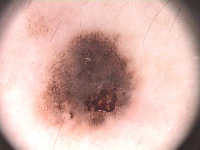</td><td>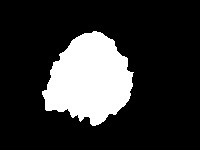</td></tr></table>

2. Разархивируем .rar файл.
3. Обратите внимание, что папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем **сегментировать** их.

In [ ]:
from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id='1DSL6y6aa9DUXGhy4kP_qz9OkEOZIbcXZ',
                                    dest_path='./PH2Dataset.rar',
                                    unzip=False)
get_ipython().system_raw("unrar x PH2Dataset.rar")

Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

 Здесь `X.bmp` — изображение, которое нужно сегментировать, `X_lesion.bmp` — результат сегментации.

Для загрузки датасета можно использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [ ]:
images = []
lesions = []
from skimage.io import imread
import os
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. Для изменения размера изображений можно использовать [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize).
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [ ]:
from skimage.transform import resize
import numpy as np
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


In [ ]:
len(lesions)

200

In [ ]:
import torch
import random
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time
from torchsummary import summary
from matplotlib import rcParams
from IPython.display import clear_output
from torch.autograd import Variable
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from IPython.display import clear_output
rcParams['figure.figsize'] = (15,4)

In [ ]:
# фиксация SEED
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

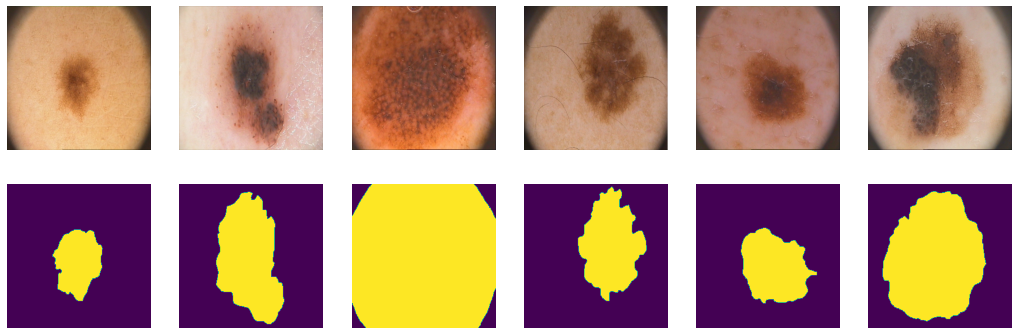

In [ ]:
plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для обучения, валидации и теста соответственно

In [ ]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [ ]:
print(len(tr), len(val), len(ts))

100 50 50


#### PyTorch DataLoader

In [ ]:
batch_size = 16

data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])), 
                     batch_size=batch_size, 
                     shuffle=True, 
                     num_workers=2)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=False, 
                      num_workers=2)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=False, 
                     num_workers=2)

In [ ]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

CUDA is available!  Training on GPU ...
cuda


In [ ]:
!nvidia-smi

Tue Nov 23 21:17:42 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    26W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Реализация различных архитектур:
Ваше задание будет состоять в том, чтобы написать несколько нейросетевых архитектур для решения задачи семантической сегментации. Сравнить их по качеству на тесте и испробовать различные лосс функции для них.

-----------------------------------------------------------------------------------------

# SegNet [2 балла]

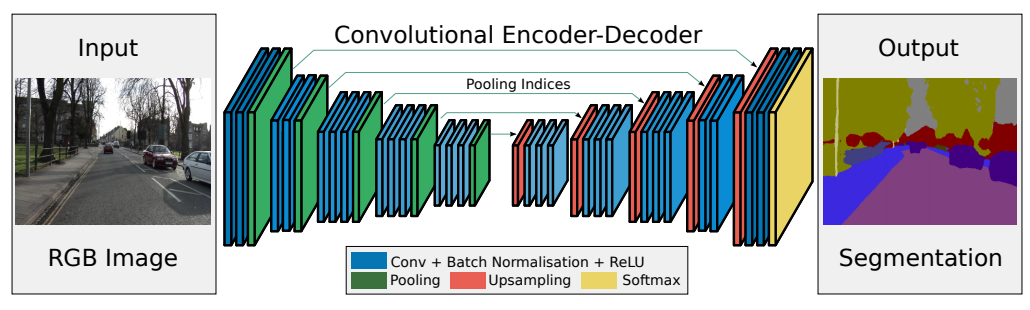

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

Внимательно посмотрите из чего состоит модель и для чего выбраны те или иные блоки.

In [ ]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )
        input_nbr = 3 #Число каналов входного изображения
        num_ch = 64 #Число каналов после свертки
        batchNorm_momentum = 0.1


        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels = input_nbr, out_channels = num_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_ch, momentum= batchNorm_momentum),
            nn.ReLU(),
            nn.Conv2d(in_channels = num_ch, out_channels = num_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_ch, momentum= batchNorm_momentum),
            nn.ReLU()
        )
        self.pool0 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)  # 256 -> 128

        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels = num_ch, out_channels = num_ch*2, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_ch*2, momentum= batchNorm_momentum),
            nn.ReLU(),
            nn.Conv2d(in_channels = num_ch*2, out_channels = num_ch*2, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_ch*2, momentum= batchNorm_momentum),
            nn.ReLU()
        )
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 128 -> 64

        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels = num_ch*2, out_channels = num_ch*4, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_ch*4, momentum= batchNorm_momentum),
            nn.ReLU(),
            nn.Conv2d(in_channels = num_ch*4, out_channels = num_ch*4, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_ch*4, momentum= batchNorm_momentum),
            nn.ReLU(),
            nn.Conv2d(in_channels = num_ch*4, out_channels = num_ch*4, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_ch*4, momentum= batchNorm_momentum),
            nn.ReLU()
        )
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 64 -> 32

        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels = num_ch*4, out_channels = num_ch*8, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_ch*8, momentum= batchNorm_momentum),
            nn.ReLU(),
            nn.Conv2d(in_channels = num_ch*8, out_channels = num_ch*8, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_ch*8, momentum= batchNorm_momentum),
            nn.ReLU(),
            nn.Conv2d(in_channels = num_ch*8, out_channels = num_ch*8, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_ch*8, momentum= batchNorm_momentum),
            nn.ReLU()
        )
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(in_channels = num_ch*8, out_channels = num_ch*8, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_ch*8, momentum= batchNorm_momentum),
            nn.ReLU(),
            nn.Conv2d(in_channels = num_ch*8, out_channels = num_ch*8, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_ch*8, momentum= batchNorm_momentum),
            nn.ReLU(),
            nn.Conv2d(in_channels = num_ch*8, out_channels = num_ch*8, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_ch*8, momentum= batchNorm_momentum),
            nn.ReLU()
        )

        self.bottleneck_pool = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        self.bottleneck_upsample = nn.MaxUnpool2d(kernel_size=2, stride=2)

        self.bottleneck_dec = nn.Sequential(          
            nn.Conv2d(in_channels=num_ch*8, out_channels=num_ch*8, kernel_size=3, padding = (1,1)),            
            nn.BatchNorm2d(num_ch*8),
            nn.ReLU(),
            nn.Conv2d(in_channels=num_ch*8, out_channels=num_ch*8, kernel_size=3, padding = (1,1)),            
            nn.BatchNorm2d(num_ch*8),
            nn.ReLU(),
            nn.Conv2d(in_channels=num_ch*8, out_channels=num_ch*8, kernel_size=3, padding = (1,1)),           
            nn.BatchNorm2d(num_ch*8),
            nn.ReLU()
        )

        # decoder (upsampling)
        self.upsample0 = nn.MaxUnpool2d(kernel_size=2, stride=2) # 16 -> 32
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(in_channels = num_ch*8, out_channels = num_ch*8, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_ch*8, momentum= batchNorm_momentum),
            nn.ReLU(),
            nn.Conv2d(in_channels = num_ch*8, out_channels = num_ch*8, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_ch*8, momentum= batchNorm_momentum),
            nn.ReLU(),
            nn.Conv2d(in_channels = num_ch*8, out_channels = num_ch*4, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_ch*4, momentum= batchNorm_momentum),
            nn.ReLU()
        )

        self.upsample1 = nn.MaxUnpool2d(kernel_size=2, stride=2) # 32 -> 64
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(in_channels = num_ch*4, out_channels = num_ch*4, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_ch*4, momentum= batchNorm_momentum),
            nn.ReLU(),
            nn.Conv2d(in_channels = num_ch*4, out_channels = num_ch*4, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_ch*4, momentum= batchNorm_momentum),
            nn.ReLU(),
            nn.Conv2d(in_channels = num_ch*4, out_channels = num_ch*2, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_ch*2, momentum= batchNorm_momentum),
            nn.ReLU()
        )

        self.upsample2 = nn.MaxUnpool2d(kernel_size=2, stride=2) # 64 -> 128
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(in_channels = num_ch*2, out_channels = num_ch*2, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_ch*2, momentum= batchNorm_momentum),
            nn.ReLU(),
            nn.Conv2d(in_channels = num_ch*2, out_channels = num_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_ch, momentum= batchNorm_momentum),
            nn.ReLU()
        )

        self.upsample3 = nn.MaxUnpool2d(kernel_size=2, stride=2)# 128 -> 256
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(in_channels = num_ch, out_channels = num_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_ch, momentum= batchNorm_momentum),
            nn.ReLU(),
            nn.Conv2d(in_channels = num_ch, out_channels = 1, kernel_size=3, padding=1)
        )

    def forward(self, x):
        # encoder
        e0 = self.enc_conv0(x)
        e0, ind0 = self.pool0(e0)
        e1 = self.enc_conv1(e0)
        e1, ind1 = self.pool1(e1)
        e2 = self.enc_conv2(e1)
        e2, ind2 = self.pool2(e2)
        e3 = self.enc_conv3(e2)
        e3, ind3 = self.pool3(e3)

        # bottleneck
        b = self.bottleneck_conv(e3)
        b, ind_b = self.bottleneck_pool(b)
        b = self.bottleneck_upsample(b, ind_b)
        b = self.bottleneck_dec(b)

        # decoder
        d0 = self.upsample0(b, ind3)
        d0 = self.dec_conv0(d0)
        d1 = self.upsample1(d0, ind2)
        d1 = self.dec_conv1(d1)
        d2 = self.upsample2(d1, ind1)
        d2 = self.dec_conv2(d2)
        d3 = self.upsample3(d2, ind0)
        d3 = self.dec_conv3(d3) # no activation  

        return d3

In [ ]:
print(summary(SegNet().to(device), (3, 256, 256)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
            Conv2d-4         [-1, 64, 256, 256]          36,928
       BatchNorm2d-5         [-1, 64, 256, 256]             128
              ReLU-6         [-1, 64, 256, 256]               0
         MaxPool2d-7  [[-1, 64, 128, 128], [-1, 64, 128, 128]]               0
            Conv2d-8        [-1, 128, 128, 128]          73,856
       BatchNorm2d-9        [-1, 128, 128, 128]             256
             ReLU-10        [-1, 128, 128, 128]               0
           Conv2d-11        [-1, 128, 128, 128]         147,584
      BatchNorm2d-12        [-1, 128, 128, 128]             256
             ReLU-13        [-1, 128, 128, 128]               0
        MaxPool2d-14  [[

## Метрика

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


Для примера посмотрим на истину (слева) и предсказание (справа):
![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)


Тогда пересечение и объединение будет выглядеть так:

![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

In [ ]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
#    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    
    return iou # thresholded

## Функция потерь [1 балл]

Не менее важным, чем построение архитектуры, является определение **оптимизатора** и **функции потерь.**

Функция потерь - это то, что мы пытаемся минимизировать. Многие из них могут быть использованы для задачи бинарной семантической сегментации. 

Популярным методом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits). Эта функция эквивалентна первой и не так подвержена численной неустойчивости:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

In [ ]:
def bce_loss(y_pred, y_real):
    # TODO 
    # please don't use nn.BCELoss. write it from scratch
    loss = torch.maximum(y_pred, torch.zeros_like(y_pred)) - y_pred*y_real + torch.log(1+torch.exp(-torch.abs(y_pred)))
    return loss.mean((1,2,3)).mean()

***Для проверки правильности реализации нашей функции bce_loss сравним результаты ее работы на случайном тензоре с результатами работы библиотечной функции nn.BCEWithLogitsLoss():***

In [ ]:
s1 = torch.randn(10, 3, 256, 256)
s2 = torch.randn(10, 3, 256, 256)
print(nn.BCEWithLogitsLoss()(s1, s2), bce_loss(s1, s2))

tensor(0.8069) tensor(0.8069)


## Тренировка [1 балл]

Мы определим цикл обучения в функции, чтобы мы могли повторно использовать его.

In [ ]:
# Некоторые глобальные константы
MAX_EPOCHS = 100
BASE_LR = 3e-4
WEIGHT_DECAY = 0.01
AMSGRAD = False

In [ ]:
def train(model, optimizer, loss_fn, epochs, data_tr, data_val, used_sheduler=True):
    X_val, Y_val = next(iter(data_val))
    history = {"epochs": np.arange(epochs)+1, "train": {"score": [], "loss": []},  "val": {"score": [], "loss": []}}
    if used_sheduler:
        scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[epochs//3,epochs//2,epochs//1.4,epochs//1.1], gamma=0.8)
        #scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.95)

    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        avg_score = 0
        avg_loss_val = 0
        avg_score_val = 0

        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
            X_batch = X_batch.to(device)  # data to device
            Y_batch = Y_batch.to(device)  # data to device

            # set parameter gradients to zero
            optimizer.zero_grad()

            # forward
            Y_pred = model(X_batch)
            loss =  loss_fn(Y_pred, Y_batch) # forward-pass
            loss.backward()  # backward-pass
            optimizer.step()  # update weights
            score = iou_pytorch(torch.sigmoid(Y_pred) > 0.5, Y_batch).mean().item()

            # calculate loss to show the user
            avg_loss += loss / len(data_tr)
            avg_score += score/ len(data_tr)
        toc = time()
        print('loss: %f' % avg_loss)
        if used_sheduler:
          scheduler.step()

        # show intermediate results
        model.eval()  # testing mode
        Y_hat = model(X_val.to(device)).detach().to("cpu") # detach and put into cpu
        loss_val = loss

        # Visualize tools
        clear_output(wait=True)

        for Xv_batch, Yv_batch in data_val:
            Xv_batch = Xv_batch.to(device)
            Yv_batch = Yv_batch.to(device)
            Y_pred_val = model(Xv_batch)
            loss_val = loss_fn(Y_pred_val, Yv_batch)
            score_val = iou_pytorch(torch.sigmoid(Y_pred_val) > 0.5, Yv_batch).mean().item()
            avg_loss_val += loss / len(data_val)
            avg_score_val += score_val/ len(data_val)
            
        history["train"]["score"].append(avg_score)
        history["val"]["score"].append(avg_score_val)
        history["train"]["loss"].append(avg_loss.item())
        history["val"]["loss"].append(avg_loss_val.item())
        fig, ax = plt.subplots(3, 6, figsize = (14, 12))

        for k in range(6):
            ax[0, k].imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
            ax[0, k].set_title("Real")
            ax[0, k].axis('off')
            ax[1, k].imshow(torch.sigmoid(Y_hat[k, 0]) > 0.5, cmap='gray')
            ax[1, k].set_title("Output")
            ax[1, k].axis('off') 
            ax[2, k].imshow(Y_val[k, 0], cmap='gray')
            ax[2, k].set_title("Ground Truth")
            ax[2, k].axis('off')                    
        plt.suptitle('%d / %d - train_loss: %f , val_loss: %f, train_score: %f, val_score: %f' % (epoch+1, epochs, avg_loss, avg_loss_val, avg_score, avg_score_val))
        plt.tight_layout()
        plt.show()

   # очистка кеша

    X_batch.to("cpu")
    Y_batch.to("cpu")
    Xv_batch.to("cpu")
    Yv_batch.to("cpu")
    del model
    del X_batch
    del Y_batch
    del Xv_batch
    del Yv_batch
    torch.cuda.empty_cache()

    return history

## Инференс [1 балл]

После обучения модели эту функцию можно использовать для прогнозирования сегментации на новых данных:

In [ ]:
def score_model(model, metric, data):
    model.eval()  # testing mode
    scores = 0
    for X_batch, Y_label in data:
        Y_pred = torch.sigmoid(model(X_batch.to(device))) > 0.5
        scores += metric(Y_pred, Y_label.to(device)).mean().item()
    return scores/len(data)

#Функция для построения графиков лосса и скора по эпохам
def make_graph(history, model_name, loss_name):
    fig, ax = plt.subplots(1, 2, figsize = (14, 7))
    x = history["epochs"]
    loss_train = history["train"]["loss"]
    loss_val = history["val"]["loss"]
    score_train = history["train"]["score"]
    score_val = history["val"]["score"]
    ax[0].plot(x, loss_train, label = "train", color = "green")
    ax[0].plot(x, loss_val, label = "val", color = "orange")
    ax[0].legend(fontsize = 14)
    ax[0].grid(linestyle = "--")
    ax[0].tick_params(labelsize = 14)
    ax[0].set_xlabel("epoch", fontsize = 14)
    ax[0].set_ylabel("loss", fontsize = 14)
    ax[0].set_title("Loss vs epoch", fontsize = 16)
    ax[0].set_xlim(left = 0, right = x.max())
    ax[0].set_ylim(bottom = 0)
    ax[1].plot(x, score_train, label = "train", color = "green")
    ax[1].plot(x, score_val, label = "val", color = "orange")
    ax[1].legend(fontsize = 14)
    ax[1].grid(linestyle = "--")
    ax[1].tick_params(labelsize = 14)
    ax[1].set_xlabel("epoch", fontsize = 14)
    ax[1].set_ylabel("score", fontsize = 14)
    ax[1].set_title("Score vs epoch", fontsize = 16)
    ax[1].set_xlim(left = 0, right = x.max())
    ax[1].set_ylim(bottom = 0)
    plt.suptitle(f"Model = {model_name}, loss = {loss_name}", fontsize = 18, y=1.05)
    plt.tight_layout()
    plt.show()

#Функция для вычисления скора на валидации и тесте уже обученной модели
def scores(model):
    val_score = score_model(model, iou_pytorch, data_val)
    test_score = score_model(model, iou_pytorch, data_ts)
    print(f"\nScore на валидации: {val_score:.4f}, score на тесте: {test_score:.4f}")
    return val_score, test_score

## Основной момент: обучение

Обучите вашу модель. Обратите внимание, что обучать необходимо до сходимости. Если указанного количества эпох (20) не хватило, попробуйте изменять количество эпох до сходимости алгоритма. Сходимость определяйте по изменению функции потерь на валидационной выборке.
 С параметрами оптимизатора можно спокойно играть, пока вы не найдете лучший вариант для себя.


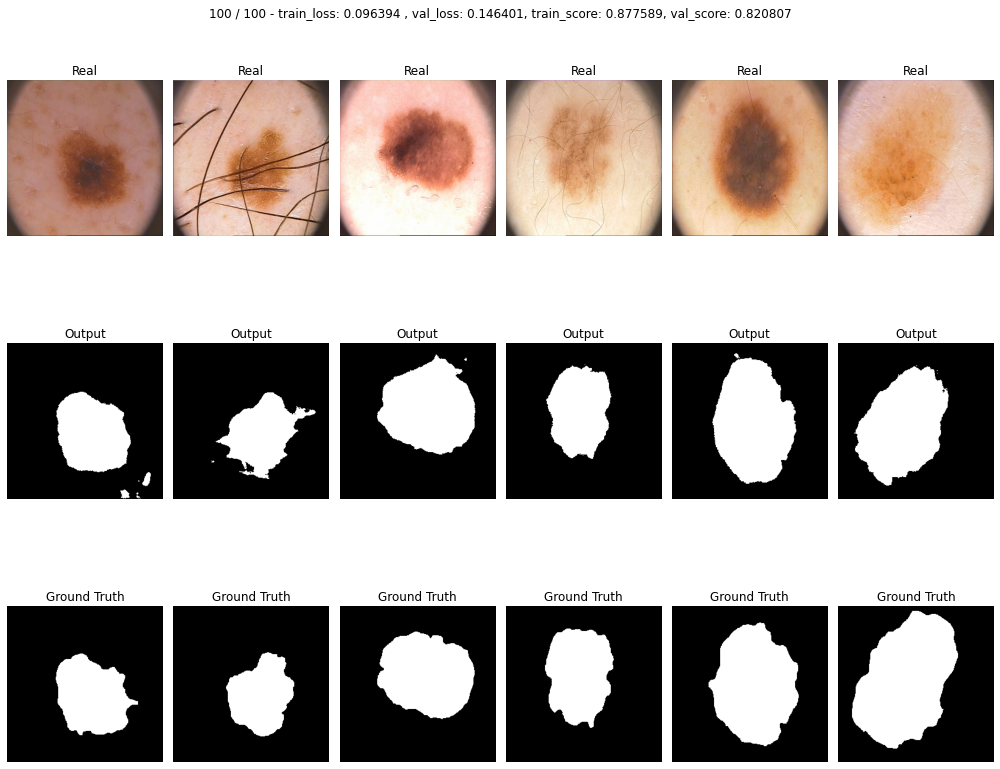

In [ ]:
model = SegNet().to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr = BASE_LR, betas=(0.9, 0.999), eps=1e-8, weight_decay=WEIGHT_DECAY, amsgrad=AMSGRAD)
h_segnet_bce = train(model, optimizer, bce_loss, MAX_EPOCHS, data_tr, data_val, used_sheduler=True)

In [ ]:
segnet_bce_val_score, segnet_bce_test_score = scores(model)


Score на валидации: 0.8208, score на тесте: 0.8318


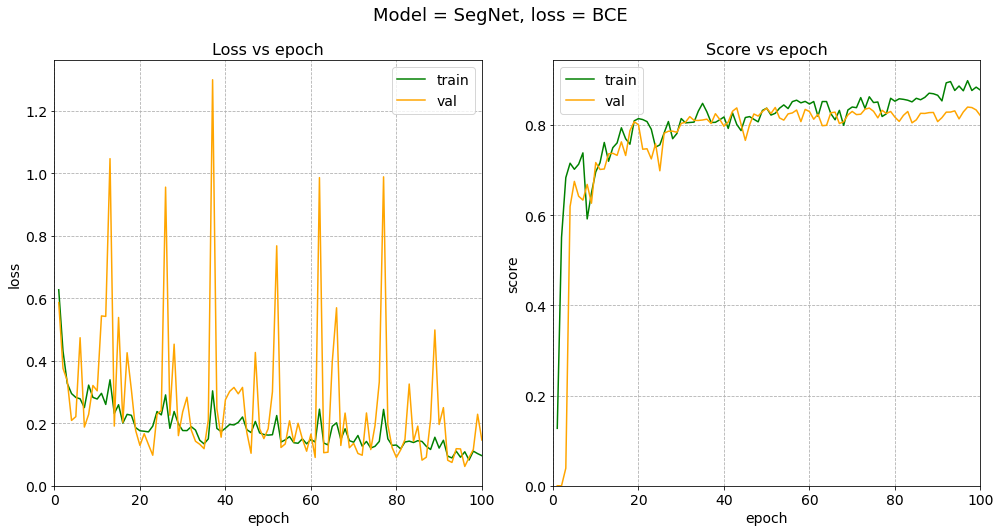

In [ ]:
make_graph(h_segnet_bce, "SegNet", "BCE")

In [ ]:
model.to("cpu")
del model
torch.cuda.empty_cache()
!nvidia-smi

Ответьте себе на вопрос: не переобучается ли моя модель?

### Переобучение модели как правило характеризуется 2 показателями: 1 - скор на трейн-датасете превышает скор на валид-датасете, 2 - наличие на графиках функции потерь и графиках метрики точности характерного момента значительного видимого отклонения лосс-функций по трейну и валиду друг от друга и схожей картины отклонения друг от друга значений метрики точности. При этом точность на трейн-данных продолжает расти, а скор на валид-данных либо неизменен, либо уменьшается. У лосс-функций при переобучении поведение зеркальное - лосс на трейне уменьшается, лосс на валиде растет. В нашей конкретной модели Segnet, оценивая вцелом результаты, можно предположить, что модель достаточно устойчива к переобучению, однако, примерно после 60 эпохи можно видеть незначительные проявления описанного процесса.

-----------------------------------------------------------------------------------------

## Дополнительные функции потерь [2 балла] 

 В данном разделе вам потребуется имплементировать две функции потерь:
 DICE и Focal loss. 
 Если у вас что-то не учится, велика вероятность, что вы ошиблись или учите слишком мало эпох, прежде чем бить тревогу попробуйте перебрать различные варианты и убедитесь, что во всех других сетапах сеть достигает желанного результата. СПОЙЛЕР: учиться она будет при всех лоссах, предложенных в этом задании.


**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \sum_i\frac{2X_iY_i}{X_i+Y_i}.$$

Не забудьте подумать о численной нестабильности, возникающей в математической формуле.


In [ ]:
def dice_loss(y_pred, y_real, smooth=1): #параметр smooth решает проблему возможной нестабильности функции
    y_pred = torch.sigmoid(y_pred)
    num = (2*y_pred*y_real).sum((1,2,3)) + smooth
    den = (y_pred + y_real).sum((1,2,3)) + smooth
    res = 1 - (num/den).mean()
    return res 

Проводим тестирование:

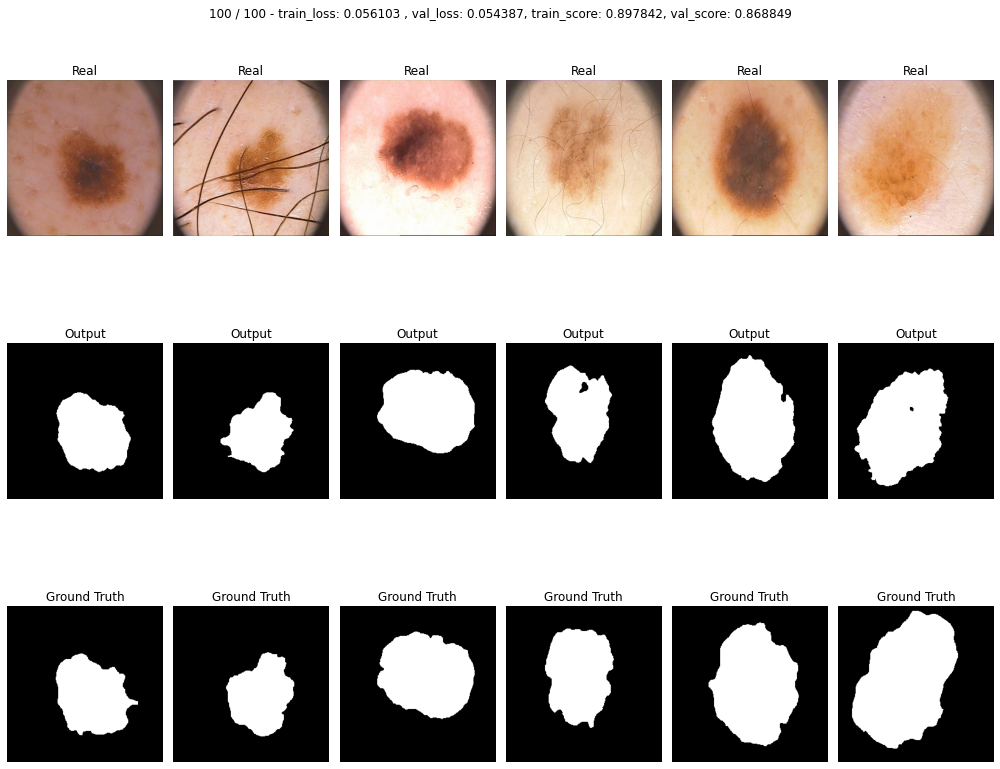

In [ ]:
model_dice = SegNet().to(device)

optimizer = torch.optim.AdamW(model_dice.parameters(), lr = BASE_LR, betas=(0.9, 0.999), eps=1e-8, weight_decay=WEIGHT_DECAY, amsgrad=AMSGRAD)
h_segnet_dice = train(model_dice, optimizer, dice_loss, MAX_EPOCHS, data_tr, data_val, used_sheduler=True)

In [ ]:
segnet_dice_val_score, segnet_dice_test_score = scores(model_dice)


Score на валидации: 0.8688, score на тесте: 0.8398


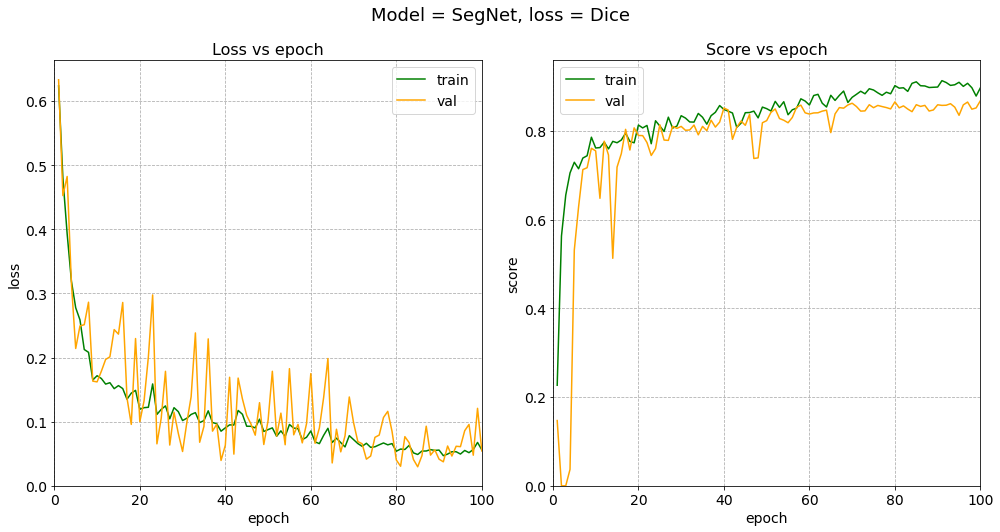

In [ ]:
make_graph(h_segnet_dice, "SegNet", "Dice")

In [ ]:
model_dice.to("cpu")
del model_dice
torch.cuda.empty_cache()
!nvidia-smi

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf) 

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.

Еще одним недавним дополнением является взвешенный пиксельный вариант, которая взвешивает каждый пиксель по степени уверенности, которую мы имеем в предсказании этого пикселя.

$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Зафиксируем значение $\gamma=2$.

--------------------------------------------------------------------------------


In [ ]:
#eps - весовой коэффициент для балансировки дисбаланса классов (default -1)

def focal_loss(y_pred, y_real, eps = -1, gamma = 2):
    p = torch.sigmoid(y_pred)
    ce_loss = torch.maximum(y_pred, torch.zeros_like(y_pred)) - y_pred*y_real + torch.log(1+torch.exp(-torch.abs(y_pred)))
    # однако, для разнообразия (!) можно было бы использовать библиотечную функцию binary_cross_entropy_with_logits
    # ce_loss = F.binary_cross_entropy_with_logits(y_pred, y_real, reduction="none")
    p_t = p * y_real + (1 - p) * (1 - y_real)
    loss = ce_loss * ((1 - p_t) ** gamma)
    if eps >= 0:
        alpha_t = eps * y_real + (1 - eps) * (1 - y_real)
        loss = alpha_t * loss
    loss = loss.mean((1,2,3)).mean()
    return loss

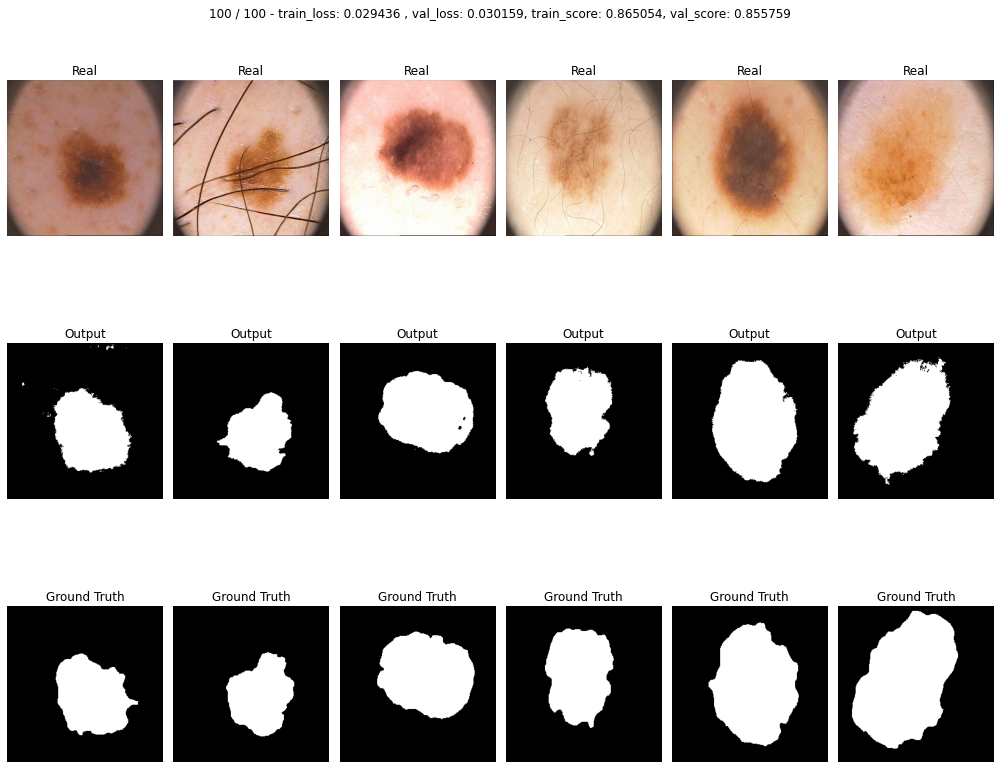

In [ ]:
model_focal = SegNet().to(device)

optimizer = torch.optim.AdamW(model_focal.parameters(), lr = BASE_LR, betas=(0.9, 0.999), eps=1e-8, weight_decay=WEIGHT_DECAY, amsgrad=AMSGRAD)
h_segnet_focal = train(model_focal, optimizer, focal_loss, MAX_EPOCHS, data_tr, data_val, used_sheduler=True)

In [ ]:
segnet_focal_val_score, segnet_focal_test_score = scores(model_focal)


Score на валидации: 0.8558, score на тесте: 0.8444


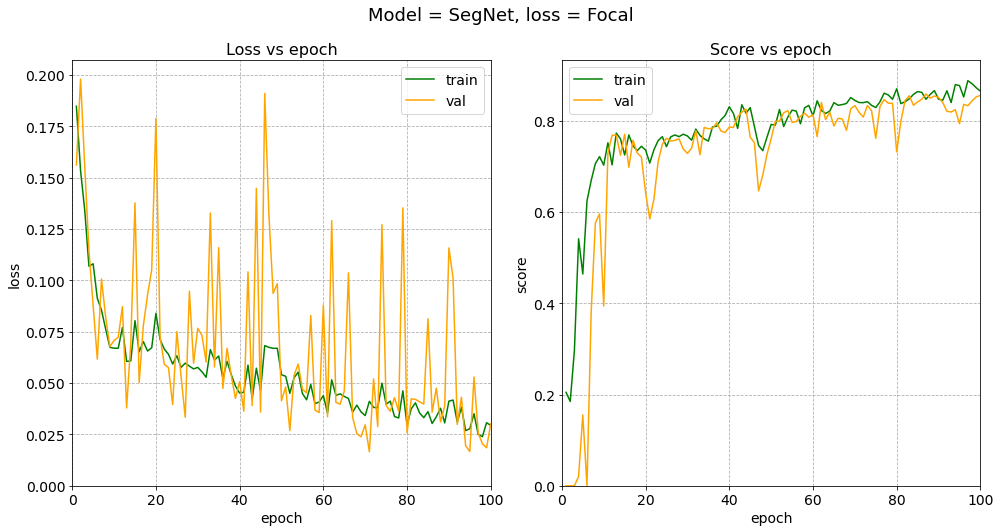

In [ ]:
make_graph(h_segnet_focal, "SegNet", "Focal")

In [ ]:
model_focal.to("cpu")
del model_focal
torch.cuda.empty_cache()
!nvidia-smi

----------------------------------------------------------------------------------------------

## [BONUS] Мир сегментационных лоссов [5 баллов]

В данном блоке предлагаем вам написать одну функцию потерь самостоятельно. Для этого необходимо прочитать статью и имплементировать ее. Кроме тако провести численное сравнение с предыдущими функциями.
Какие варианты? 

1) Можно учесть Total Variation
2) Lova
3) BCE но с Soft Targets (что-то типа label-smoothing для многослассовой классификации)
4) Любой другой 

* [Physiological Inspired Deep Neural Networks for Emotion Recognition](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8472816&tag=1)". IEEE Access, 6, 53930-53943.

* [Boundary loss for highly unbalanced segmentation](https://arxiv.org/abs/1812.07032)

* [Tversky loss function for image segmentation using 3D fully convolutional deep networks](https://arxiv.org/abs/1706.05721)

* [Correlation Maximized Structural Similarity Loss for Semantic Segmentation](https://arxiv.org/abs/1910.08711)

* [Topology-Preserving Deep Image Segmentation](https://papers.nips.cc/paper/8803-topology-preserving-deep-image-segmentation)

Так как Тверский лосс очень похож на данные выше, то за него будет проставлено только 3 балла (при условии, если в модели нет ошибок при обучении). Постарайтесь сделать что-то интереснее.

* [Имплементация различных функций потерь (очень большая подборка)](https://github.com/JunMa11/SegLoss)

# Важная РЕМАРКА!!!! Численное сравнение с другими функциями потерь приведено в последнем блоке работы (в отчете)

# Lovasz Hinge Loss

Эта комплексная функция потерь была введена Берманом, Трики и Блашко в их статье "Функция потерь Ловаша: допустимая замена для оптимизации меры пересечения по объединению (𝐼𝑜𝑈) в нейронных сетях". Она предназначена для оптимизации показателя пересечения по объединению для семантической сегментации, особенно для экземпляров с несколькими классами. В частности, она сортирует прогнозы по их ошибке, прежде чем вычислять совокупно, как каждая ошибка влияет на оценку 𝐼𝑜𝑈. Этот вектор градиента затем умножается на начальный вектор ошибок, чтобы наиболее сильно скорректировать прогнозы, которые больше всего снизили итоговую точность модели. Данная конкретная имплементации функции потерь является бинарным вариантом реализации (lovasz_hinge). Используемый Lovasz-функцией индекс Жаккара, также называемый оценкой пересечения по сравнению с объединением, обычно применяется при оценке результатов сегментации изображения с учетом его перцептивных качеств, масштабной инвариантности, что придает соответствующую релевантность маленьким объектам и соответствующий подсчет ложноотрицательных результатов в сравнение с потерями на пиксель. Функция использует метод прямой оптимизации средней потери пересечения по объединению в нейронных сетях в контексте семантической сегментации изображения, основанный на выпуклом расширении Ловаша субмодульных потерь.

In [ ]:
def lovasz_loss(logits, labels, per_image=True, ignore=None):
    """
    Binary Lovasz hinge loss
      logits: [B, H, W] Variable, logits at each pixel (between -\infty and +\infty)
      labels: [B, H, W] Tensor, binary ground truth masks (0 or 1)
      per_image: compute the loss per image instead of per batch
      ignore: void class id
    """
    if per_image:
        loss = mean(lovasz_hinge_flat(*flatten_binary_scores(log.unsqueeze(0), lab.unsqueeze(0), ignore))
                          for log, lab in zip(logits, labels))
    else:
        loss = lovasz_hinge_flat(*flatten_binary_scores(logits, labels, ignore))
    return loss

def lovasz_hinge_flat(logits, labels):
    """
    Binary Lovasz hinge loss
      logits: [P] Variable, logits at each prediction (between -\infty and +\infty)
      labels: [P] Tensor, binary ground truth labels (0 or 1)
      ignore: label to ignore
    """
    if len(labels) == 0:
        # only void pixels, the gradients should be 0
        return logits.sum() * 0.
    signs = 2. * labels.float() - 1.
    errors = (1. - logits * Variable(signs))
    errors_sorted, perm = torch.sort(errors, dim=0, descending=True)
    perm = perm.data
    gt_sorted = labels[perm]
    grad = lovasz_grad(gt_sorted)
    loss = torch.dot(F.relu(errors_sorted), Variable(grad))
    return loss


def flatten_binary_scores(scores, labels, ignore=None): #
    """
    Flattens predictions in the batch (binary case)
    Remove labels equal to 'ignore'
    """
    scores = scores.view(-1)
    labels = labels.view(-1)
    if ignore is None:
        return scores, labels
    valid = (labels != ignore)
    vscores = scores[valid]
    vlabels = labels[valid]
    return vscores, vlabels

# --------------------------- HELPER FUNCTIONS ---------------------------
def isnan(x):
    return x != x
    
def mean(l, ignore_nan=False, empty=0):
    """
    nanmean compatible with generators.
    """
    l = iter(l)
    if ignore_nan:
        l = ifilterfalse(isnan, l)
    try:
        n = 1
        acc = next(l)
    except StopIteration:
        if empty == 'raise':
            raise ValueError('Empty mean')
        return empty
    for n, v in enumerate(l, 2):
        acc += v
    if n == 1:
        return acc
    return acc / n

def lovasz_grad(gt_sorted):
    """
    Computes gradient of the Lovasz extension w.r.t sorted errors
    See Alg. 1 in paper
    """
    p = len(gt_sorted)
    gts = gt_sorted.sum()
    intersection = gts - gt_sorted.float().cumsum(0)
    union = gts + (1 - gt_sorted).float().cumsum(0)
    jaccard = 1. - intersection / union
    if p > 1: # cover 1-pixel case
        jaccard[1:p] = jaccard[1:p] - jaccard[0:-1]
    return jaccard

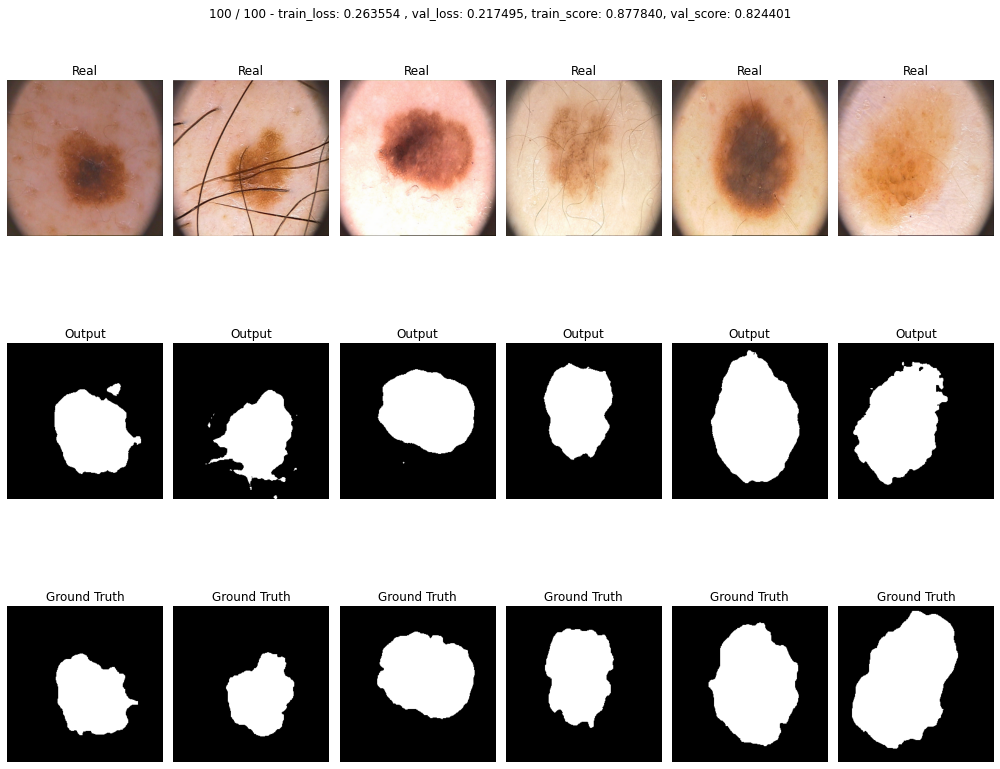

In [ ]:
model_lovasz = SegNet().to(device)

optimizer = torch.optim.AdamW(model_lovasz.parameters(), lr = BASE_LR, betas=(0.9, 0.999), eps=1e-8, weight_decay=WEIGHT_DECAY, amsgrad=AMSGRAD)
h_segnet_lovasz = train(model_lovasz, optimizer, lovasz_loss, MAX_EPOCHS, data_tr, data_val, used_sheduler=True)

In [ ]:
segnet_lovasz_val_score, segnet_lovasz_test_score = scores(model_lovasz)


Score на валидации: 0.8244, score на тесте: 0.8460


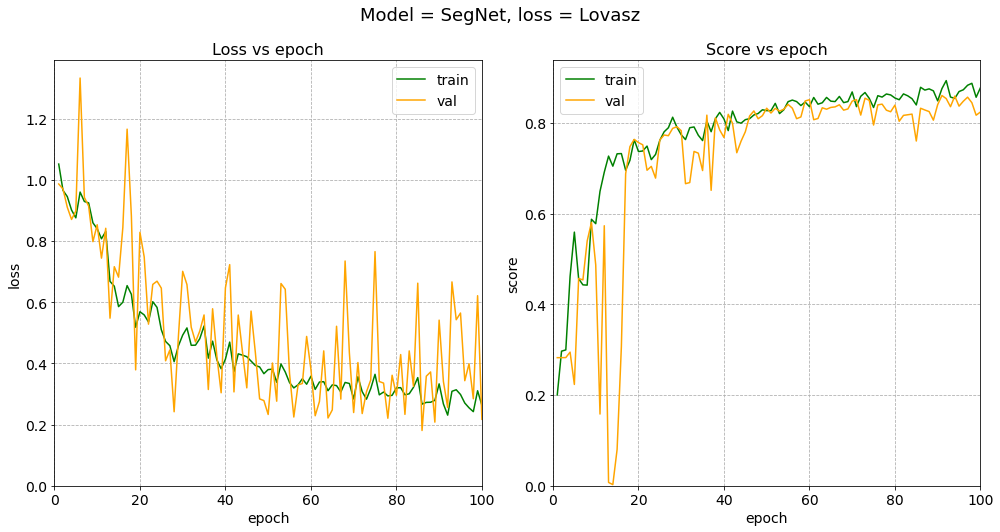

In [ ]:
make_graph(h_segnet_lovasz, "SegNet", "Lovasz")

In [ ]:
model_lovasz.to("cpu")
del model_lovasz
torch.cuda.empty_cache()
!nvidia-smi

-----------------------------------------------------------------------------------------

# U-Net [2 балла]

[**U-Net**](https://arxiv.org/abs/1505.04597) — это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Получая на вход медицинское изображение, он выведет изображение в оттенках серого, где интенсивность каждого пикселя зависит от вероятности того, что этот пиксель принадлежит интересующей нас области.

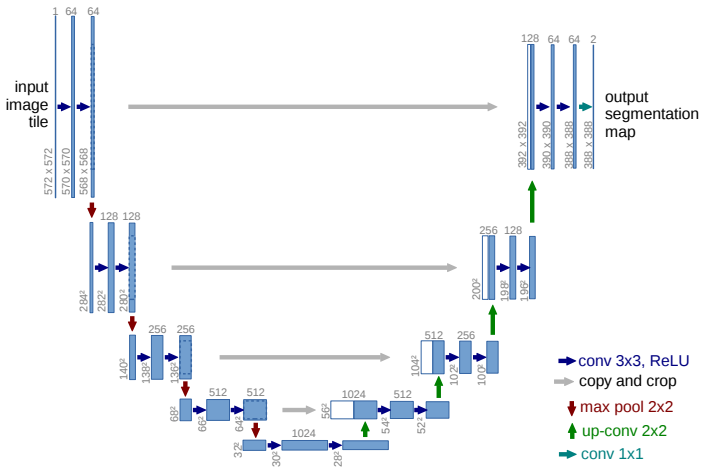

У нас в архитектуре все так же существует энкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются *skip-conenctions*, соединяющие части декодера и энкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

# *UNet + BCE-loss*

In [ ]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        input_nbr = 3 #Число каналов входного изображения
        num_ch = 64 #Число каналов после свертки
        batchNorm_momentum = 0.1

        # encoder (downsampling)
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=input_nbr, out_channels = num_ch, kernel_size=3, padding = (1,1)),  
            nn.BatchNorm2d(num_ch, momentum= batchNorm_momentum),
            nn.ReLU(),
            nn.Conv2d(in_channels=num_ch, out_channels=num_ch, kernel_size=3, padding = (1,1)),           
            nn.BatchNorm2d(num_ch, momentum= batchNorm_momentum),
            nn.ReLU()
        )
        
        self.pool0 = nn.MaxPool2d(kernel_size = 2, return_indices = False)
        
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels = num_ch, out_channels = num_ch*2, kernel_size=3, padding = (1,1)),            
            nn.BatchNorm2d(num_ch*2, momentum= batchNorm_momentum),
            nn.ReLU(),
            nn.Conv2d(in_channels=num_ch*2, out_channels=num_ch*2, kernel_size=3, padding = (1,1)),            
            nn.BatchNorm2d(num_ch*2, momentum= batchNorm_momentum),
            nn.ReLU()
        )
        
        self.pool1 = nn.MaxPool2d(kernel_size = 2, return_indices = False)
        
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels= num_ch*2, out_channels=num_ch*4, kernel_size=3, padding = (1,1)),            
            nn.BatchNorm2d(num_ch*4, momentum= batchNorm_momentum),
            nn.ReLU(),
            nn.Conv2d(in_channels=num_ch*4, out_channels=num_ch*4, kernel_size=3, padding = (1,1)),            
            nn.BatchNorm2d(num_ch*4, momentum= batchNorm_momentum),
            nn.ReLU()
        )
        
        self.pool2 = nn.MaxPool2d(kernel_size = 2, return_indices = False)
        
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=num_ch*4, out_channels=num_ch*8, kernel_size=3, padding = (1,1)),        
            nn.BatchNorm2d(num_ch*8, momentum= batchNorm_momentum),
            nn.ReLU(),
            nn.Conv2d(in_channels=num_ch*8, out_channels=num_ch*8, kernel_size=3, padding = (1,1)),           
            nn.BatchNorm2d(num_ch*8, momentum= batchNorm_momentum),
            nn.ReLU()
        )
        
        self.pool3 = nn.MaxPool2d(kernel_size = 2, return_indices = False)
            
          
        self.bottleneck_enc = nn.Sequential(
            nn.Conv2d(in_channels=num_ch*8, out_channels=num_ch*16, kernel_size=3, padding = (1,1)),           
            nn.BatchNorm2d(num_ch*16, momentum= batchNorm_momentum),
            nn.ReLU(),
            nn.Conv2d(in_channels=num_ch*16, out_channels=num_ch*8, kernel_size=3, padding = (1,1)),            
            nn.BatchNorm2d(num_ch*8, momentum= batchNorm_momentum),
            nn.ReLU()
        )        
                             
            
        # decoder (upsampling)
        self.upsample0 =  nn.Upsample(scale_factor=2)
        
        self.dec_conv0 =  nn.Sequential(
            nn.Conv2d(in_channels=num_ch*16, out_channels=num_ch*8, kernel_size=3, padding = (1,1)),            
            nn.BatchNorm2d(num_ch*8, momentum= batchNorm_momentum),
            nn.ReLU(),
            nn.Conv2d(in_channels=num_ch*8, out_channels=num_ch*4, kernel_size=3, padding = (1,1)),            
            nn.BatchNorm2d(num_ch*4, momentum= batchNorm_momentum),
            nn.ReLU()
        )       
        
        self.upsample1 =  nn.Upsample(scale_factor=2)
        
        self.dec_conv1 =  nn.Sequential(
            nn.Conv2d(in_channels=num_ch*8, out_channels=num_ch*4, kernel_size=3, padding = (1,1)),            
            nn.BatchNorm2d(num_ch*4, momentum= batchNorm_momentum),
            nn.ReLU(),
            nn.Conv2d(in_channels=num_ch*4, out_channels=num_ch*2, kernel_size=3, padding = (1,1)),           
            nn.BatchNorm2d(num_ch*2, momentum= batchNorm_momentum),
            nn.ReLU()
        )
        
        self.upsample2 =  nn.Upsample(scale_factor=2)
        
        self.dec_conv2 =  nn.Sequential(
            nn.Conv2d(in_channels=num_ch*4, out_channels=num_ch*2, kernel_size=3, padding = (1,1)),            
            nn.BatchNorm2d(num_ch*2, momentum= batchNorm_momentum),
            nn.ReLU(),
            nn.Conv2d(in_channels=num_ch*2, out_channels=num_ch, kernel_size=3, padding = (1,1)),           
            nn.BatchNorm2d(num_ch, momentum= batchNorm_momentum),
            nn.ReLU()
        )

        self.upsample3 = nn.Upsample(scale_factor=2) 
        
        self.dec_conv3 =  nn.Sequential(
            nn.Conv2d(in_channels=num_ch*2, out_channels=num_ch, kernel_size=3, padding = (1,1)),            
            nn.BatchNorm2d(num_ch, momentum= batchNorm_momentum),
            nn.ReLU(),
            nn.Conv2d(in_channels=num_ch, out_channels=num_ch, kernel_size=3, padding = (1,1)),
            nn.BatchNorm2d(num_ch, momentum= batchNorm_momentum),
            nn.ReLU(),
            nn.Conv2d(in_channels=num_ch, out_channels=1, kernel_size=1)
        )
        
        
        
    def forward(self, x):
        # encoder
        e0 = self.enc_conv0(x)
        e1 = self.pool0(e0)
        e2 = self.enc_conv1(e1)
        e3 = self.pool1(e2)
        e4 = self.enc_conv2(e3)
        e5 = self.pool2(e4)
        e6 = self.enc_conv3(e5)
        e7 = self.pool3(e6)

        # bottleneck
        b = self.bottleneck_enc(e7)

        # decoder
        d0 = self.upsample0(b)
        d0 = self.dec_conv0(torch.cat((d0,e6), dim =1))
        d1 = self.upsample1(d0)
        d1 = self.dec_conv1(torch.cat((d1,e4), dim =1))        
        d2 = self.upsample2(d1)
        d2 = self.dec_conv2(torch.cat((d2,e2), dim =1))           
        d3 = self.upsample3(d2)
        d3 = self.dec_conv3(torch.cat((d3,e0), dim =1))  
        return d3

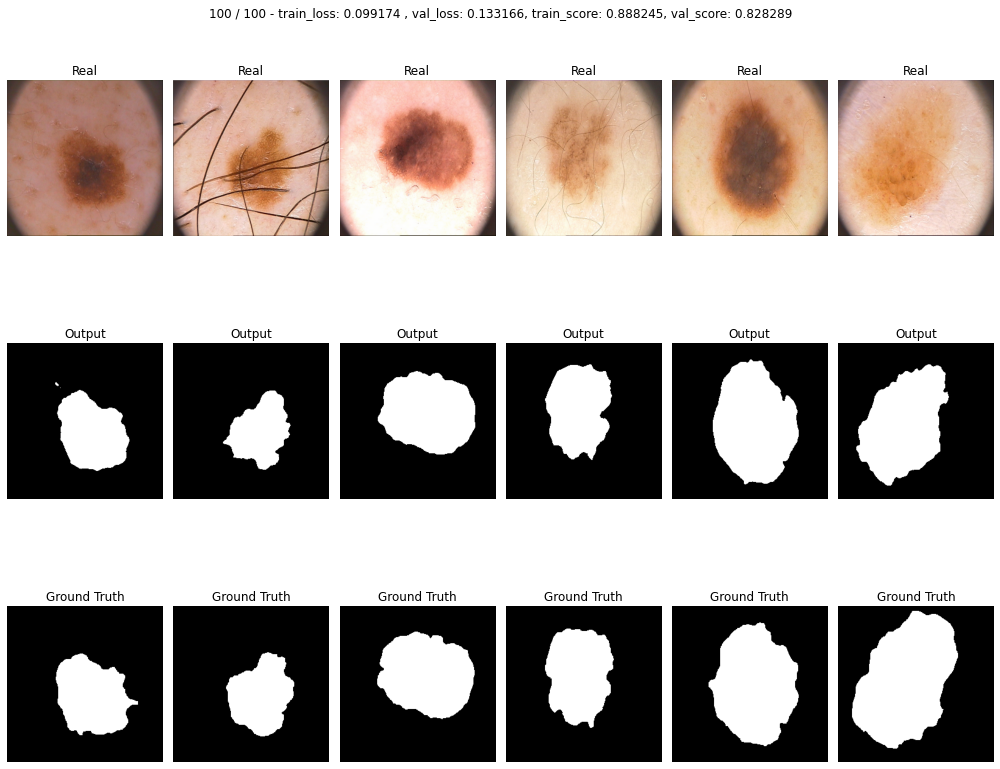

In [ ]:
unet_bce = UNet().to(device)

optimizer = torch.optim.AdamW(unet_bce.parameters(), lr = BASE_LR, betas=(0.9, 0.999), eps=1e-8, weight_decay=WEIGHT_DECAY, amsgrad=AMSGRAD)
h_unet_bce = train(unet_bce, optimizer, bce_loss, MAX_EPOCHS, data_tr, data_val, used_sheduler=True)

In [ ]:
unet_bce_val_score, unet_bce_test_score = scores(unet_bce)


Score на валидации: 0.8283, score на тесте: 0.8328


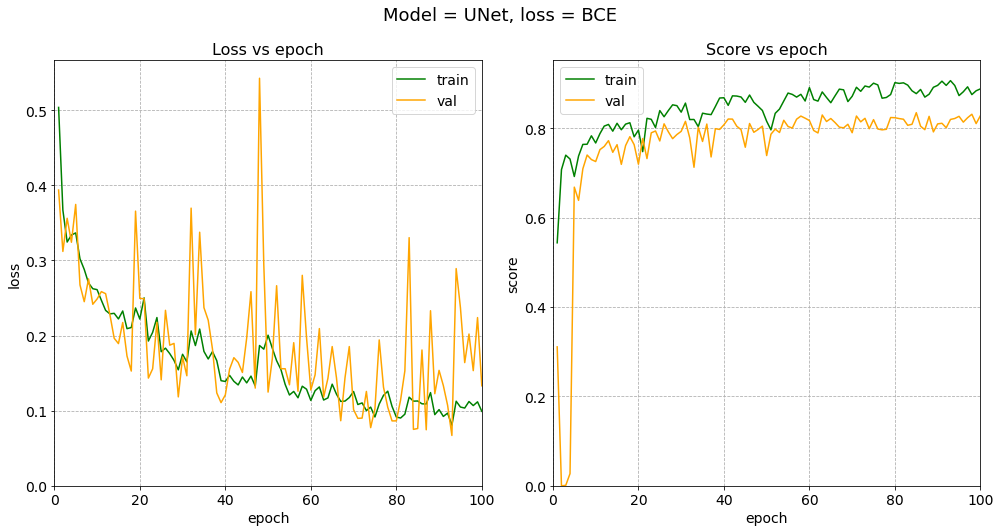

In [ ]:
make_graph(h_unet_bce, "UNet", "BCE")

In [ ]:
unet_bce.to("cpu")
del unet_bce
torch.cuda.empty_cache()
!nvidia-smi


# *UNet + dice loss*

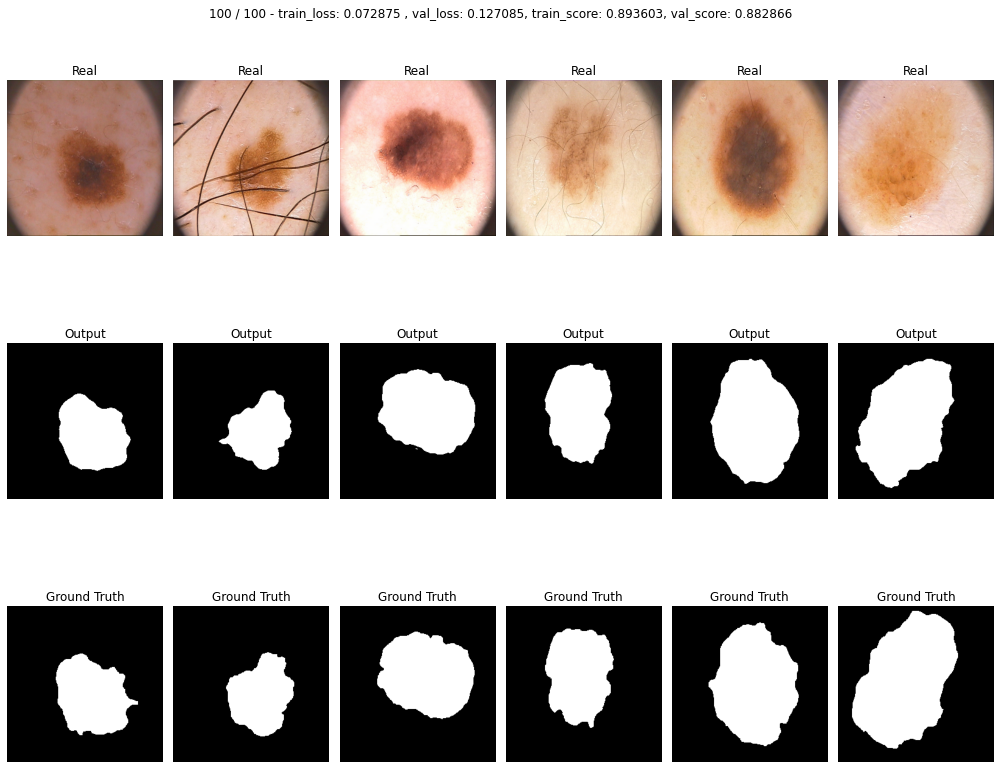

In [ ]:
unet_dice = UNet().to(device)

optimizer = torch.optim.AdamW(unet_dice.parameters(), lr = BASE_LR, betas=(0.9, 0.999), eps=1e-8, weight_decay=WEIGHT_DECAY, amsgrad=AMSGRAD)
h_unet_dice = train(unet_dice, optimizer, dice_loss, MAX_EPOCHS, data_tr, data_val, used_sheduler=True)

In [ ]:
unet_dice_val_score, unet_dice_test_score = scores(unet_dice)


Score на валидации: 0.8829, score на тесте: 0.8668


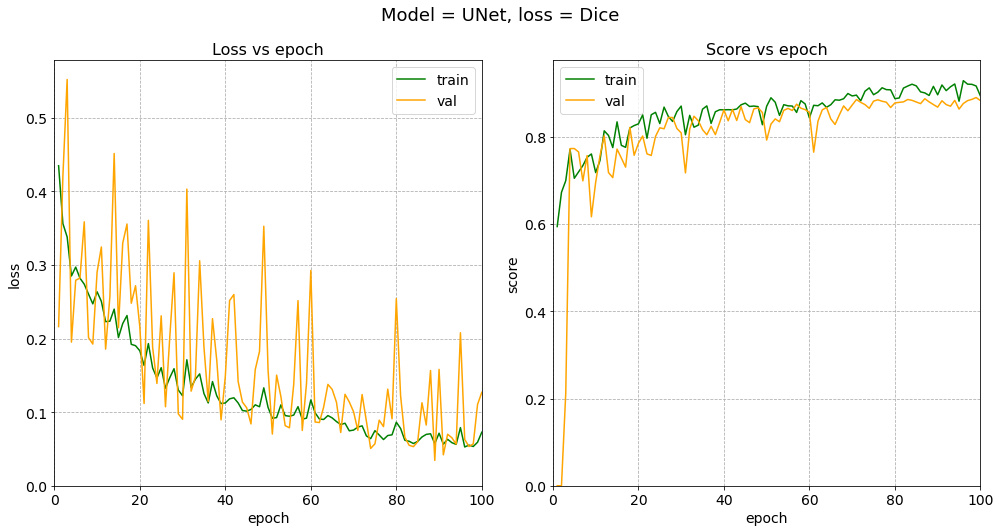

In [ ]:
make_graph(h_unet_dice, "UNet", "Dice")

In [ ]:
unet_dice.to("cpu")
del unet_dice
torch.cuda.empty_cache()
!nvidia-smi

# *UNet + focal loss*

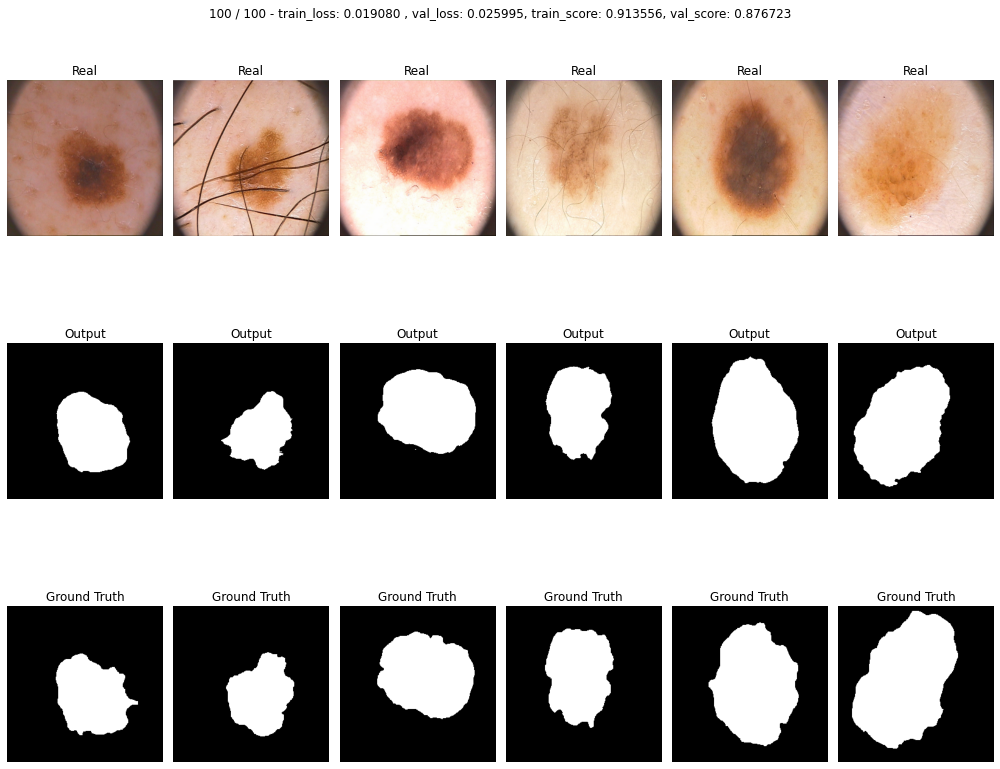

In [ ]:
unet_focal = UNet().to(device)

optimizer = torch.optim.AdamW(unet_focal.parameters(), lr = BASE_LR, betas=(0.9, 0.999), eps=1e-8, weight_decay=WEIGHT_DECAY, amsgrad=AMSGRAD)
h_unet_focal = train(unet_focal, optimizer, focal_loss, MAX_EPOCHS, data_tr, data_val, used_sheduler=True)

In [ ]:
unet_focal_val_score, unet_focal_test_score = scores(unet_focal)


Score на валидации: 0.8767, score на тесте: 0.8529


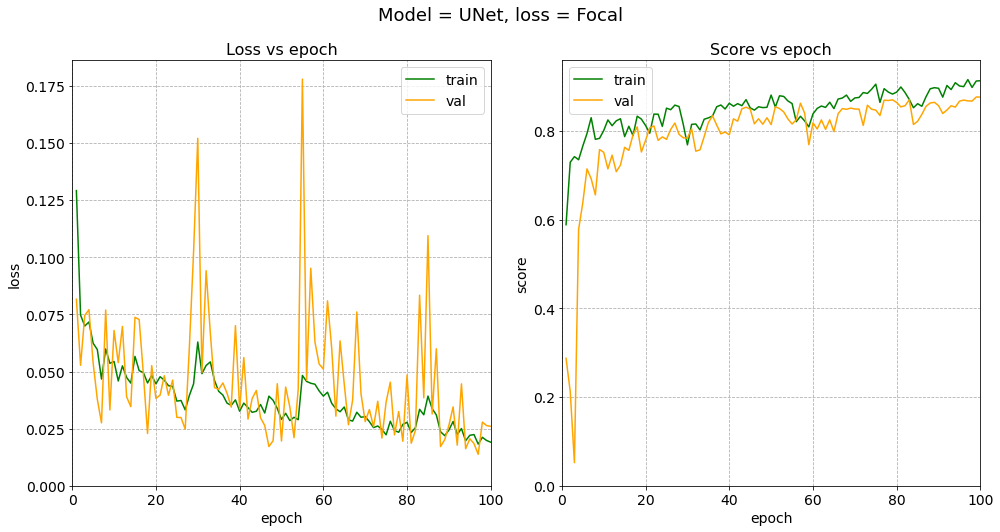

In [ ]:
make_graph(h_unet_focal, "UNet", "Focal")

In [ ]:
unet_focal.to("cpu")
del unet_focal
torch.cuda.empty_cache()
!nvidia-smi

# *UNet + Lovasz loss*

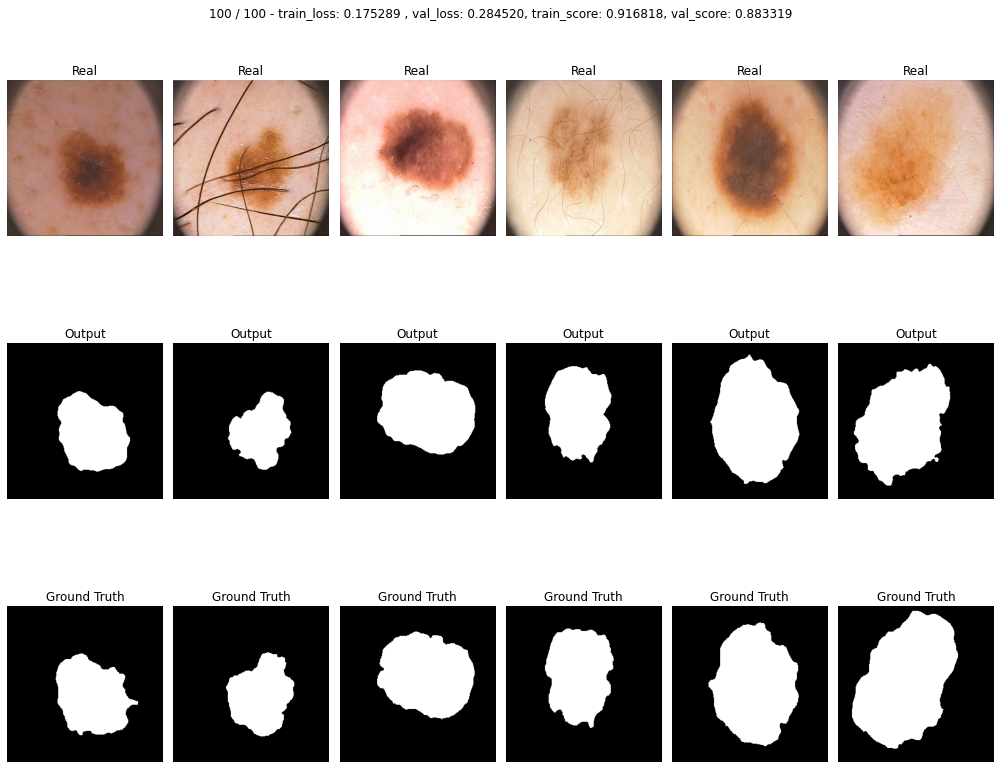

In [ ]:
unet_lovasz = UNet().to(device)

optimizer = torch.optim.AdamW(unet_lovasz.parameters(), lr = BASE_LR, betas=(0.9, 0.999), eps=1e-8, weight_decay=WEIGHT_DECAY, amsgrad=AMSGRAD)
h_unet_lovasz = train(unet_lovasz, optimizer, lovasz_loss, MAX_EPOCHS, data_tr, data_val, used_sheduler=True)

In [ ]:
unet_lovasz_val_score, unet_lovasz_test_score = scores(unet_lovasz)


Score на валидации: 0.8833, score на тесте: 0.8654


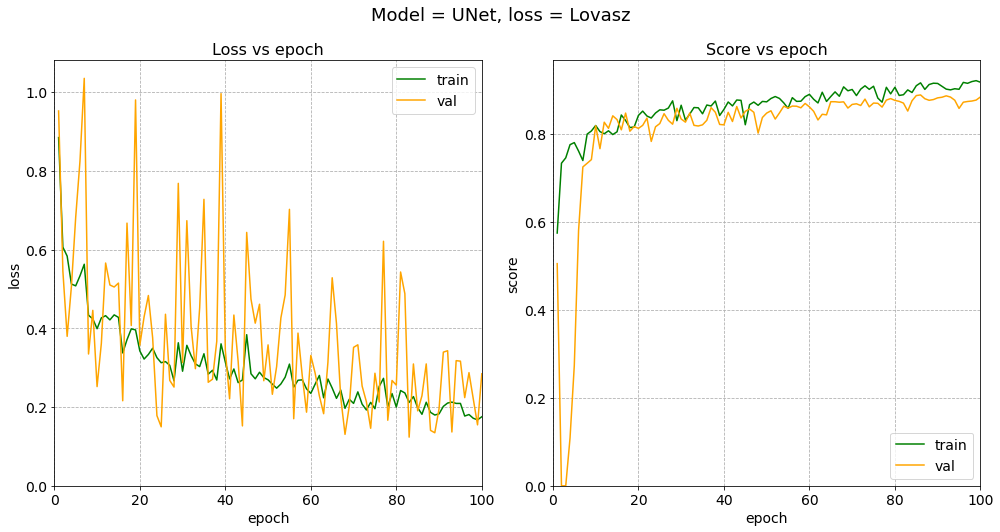

In [ ]:
make_graph(h_unet_lovasz, "UNet", "Lovasz")

In [ ]:
unet_lovasz.to("cpu")
del unet_lovasz
torch.cuda.empty_cache()
!nvidia-smi

Новая модель путем изменения типа пулинга:

 **Max-Pooling** for the downsampling and **nearest-neighbor Upsampling** for the upsampling.

Down-sampling:

        conv = nn.Conv2d(3, 64, 3, padding=1)
        pool = nn.MaxPool2d(3, 2, padding=1)

Up-Sampling

        upsample = nn.Upsample(32)
        conv = nn.Conv2d(64, 64, 3, padding=1)

Замените max-pooling на convolutions с stride=2 и upsampling на transpose-convolutions с stride=2.


In [ ]:
class UNet2(nn.Module):
    def __init__(self):
        super().__init__()

        input_nbr = 3 #Число каналов входного изображения
        num_ch = 64 #Число каналов после свертки
        batchNorm_momentum = 0.1

        # encoder (downsampling)
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=input_nbr, out_channels = num_ch, kernel_size=3, padding = (1,1)),  
            nn.BatchNorm2d(num_ch, momentum= batchNorm_momentum),
            nn.ReLU(),
            nn.Conv2d(in_channels=num_ch, out_channels=num_ch, kernel_size=3, padding = (1,1)),           
            nn.BatchNorm2d(num_ch, momentum= batchNorm_momentum),
            nn.ReLU()
        )
        
        self.pool0 = nn.Sequential(nn.Conv2d(in_channels=num_ch, out_channels = num_ch, 
                                             kernel_size = 2, stride = 2),
        nn.BatchNorm2d(num_ch),
        nn.ReLU()
        )

        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels = num_ch, out_channels = num_ch*2, kernel_size=3, padding = (1,1)),            
            nn.BatchNorm2d(num_ch*2, momentum= batchNorm_momentum),
            nn.ReLU(),
            nn.Conv2d(in_channels=num_ch*2, out_channels=num_ch*2, kernel_size=3, padding = (1,1)),            
            nn.BatchNorm2d(num_ch*2, momentum= batchNorm_momentum),
            nn.ReLU()
        )
        
        self.pool1 = nn.Sequential(nn.Conv2d(in_channels=num_ch*2, out_channels = num_ch*2, 
                                             kernel_size = 2, stride = 2),
        nn.BatchNorm2d(num_ch*2),
        nn.ReLU()
        )
        
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels= num_ch*2, out_channels=num_ch*4, kernel_size=3, padding = (1,1)),            
            nn.BatchNorm2d(num_ch*4, momentum= batchNorm_momentum),
            nn.ReLU(),
            nn.Conv2d(in_channels=num_ch*4, out_channels=num_ch*4, kernel_size=3, padding = (1,1)),            
            nn.BatchNorm2d(num_ch*4, momentum= batchNorm_momentum),
            nn.ReLU()
        )
        
        self.pool2 = nn.Sequential(nn.Conv2d(in_channels=num_ch*4, out_channels = num_ch*4, 
                                             kernel_size = 2, stride = 2),
        nn.BatchNorm2d(num_ch*4),
        nn.ReLU()
        )
        
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=num_ch*4, out_channels=num_ch*8, kernel_size=3, padding = (1,1)),        
            nn.BatchNorm2d(num_ch*8, momentum= batchNorm_momentum),
            nn.ReLU(),
            nn.Conv2d(in_channels=num_ch*8, out_channels=num_ch*8, kernel_size=3, padding = (1,1)),           
            nn.BatchNorm2d(num_ch*8, momentum= batchNorm_momentum),
            nn.ReLU()
        )
        
        self.pool3 = nn.Sequential(nn.Conv2d(in_channels=num_ch*8, out_channels = num_ch*8, 
                                             kernel_size = 2, stride = 2),
        nn.BatchNorm2d(num_ch*8),
        nn.ReLU()
        )
            
        self.bottleneck_enc = nn.Sequential(
            nn.Conv2d(in_channels=num_ch*8, out_channels=num_ch*16, kernel_size=3, padding = (1,1)),           
            nn.BatchNorm2d(num_ch*16, momentum= batchNorm_momentum),
            nn.ReLU(),
            nn.Conv2d(in_channels=num_ch*16, out_channels=num_ch*8, kernel_size=3, padding = (1,1)),            
            nn.BatchNorm2d(num_ch*8, momentum= batchNorm_momentum),
            nn.ReLU()
        )        
                             
            
        # decoder (upsampling)
        self.upsample0 = nn.Sequential(nn.ConvTranspose2d(in_channels=num_ch*8, out_channels = num_ch*8, 
                                             kernel_size = 2, stride = 2),
        nn.BatchNorm2d(num_ch*8),
        nn.ReLU()
        )
        
        self.dec_conv0 =  nn.Sequential(
            nn.Conv2d(in_channels=num_ch*16, out_channels=num_ch*8, kernel_size=3, padding = (1,1)),            
            nn.BatchNorm2d(num_ch*8, momentum= batchNorm_momentum),
            nn.ReLU(),
            nn.Conv2d(in_channels=num_ch*8, out_channels=num_ch*4, kernel_size=3, padding = (1,1)),            
            nn.BatchNorm2d(num_ch*4, momentum= batchNorm_momentum),
            nn.ReLU()
        )       
        
        self.upsample1 = nn.Sequential(nn.ConvTranspose2d(in_channels=num_ch*4, out_channels = num_ch*4, 
                                             kernel_size = 2, stride = 2),
        nn.BatchNorm2d(num_ch*4),
        nn.ReLU()
        )
        
        self.dec_conv1 =  nn.Sequential(
            nn.Conv2d(in_channels=num_ch*8, out_channels=num_ch*4, kernel_size=3, padding = (1,1)),            
            nn.BatchNorm2d(num_ch*4, momentum= batchNorm_momentum),
            nn.ReLU(),
            nn.Conv2d(in_channels=num_ch*4, out_channels=num_ch*2, kernel_size=3, padding = (1,1)),           
            nn.BatchNorm2d(num_ch*2, momentum= batchNorm_momentum),
            nn.ReLU()
        )
        
        self.upsample2 = nn.Sequential(nn.ConvTranspose2d(in_channels=num_ch*2, out_channels = num_ch*2, 
                                             kernel_size = 2, stride = 2),
        nn.BatchNorm2d(num_ch*2),
        nn.ReLU()
        )
        
        self.dec_conv2 =  nn.Sequential(
            nn.Conv2d(in_channels=num_ch*4, out_channels=num_ch*2, kernel_size=3, padding = (1,1)),            
            nn.BatchNorm2d(num_ch*2, momentum= batchNorm_momentum),
            nn.ReLU(),
            nn.Conv2d(in_channels=num_ch*2, out_channels=num_ch, kernel_size=3, padding = (1,1)),           
            nn.BatchNorm2d(num_ch, momentum= batchNorm_momentum),
            nn.ReLU()
        )

        self.upsample3 = nn.Sequential(nn.ConvTranspose2d(in_channels=num_ch, out_channels = num_ch, 
                                             kernel_size = 2, stride = 2),
        nn.BatchNorm2d(num_ch),
        nn.ReLU()
        )
        
        self.dec_conv3 =  nn.Sequential(
            nn.Conv2d(in_channels=num_ch*2, out_channels=num_ch, kernel_size=3, padding = (1,1)),            
            nn.BatchNorm2d(num_ch, momentum= batchNorm_momentum),
            nn.ReLU(),
            nn.Conv2d(in_channels=num_ch, out_channels=num_ch, kernel_size=3, padding = (1,1)),
            nn.BatchNorm2d(num_ch, momentum= batchNorm_momentum),
            nn.ReLU(),
            nn.Conv2d(in_channels=num_ch, out_channels=1, kernel_size=1)
        )
        
        
        
    def forward(self, x):
        # encoder
        e0 = self.enc_conv0(x)
        e1 = self.pool0(e0)
        e2 = self.enc_conv1(e1)
        e3 = self.pool1(e2)
        e4 = self.enc_conv2(e3)
        e5 = self.pool2(e4)
        e6 = self.enc_conv3(e5)
        e7 = self.pool3(e6)

        # bottleneck
        b = self.bottleneck_enc(e7)

        # decoder
        d0 = self.upsample0(b)
        d0 = self.dec_conv0(torch.cat((d0,e6), dim =1))
        d1 = self.upsample1(d0)
        d1 = self.dec_conv1(torch.cat((d1,e4), dim =1))        
        d2 = self.upsample2(d1)
        d2 = self.dec_conv2(torch.cat((d2,e2), dim =1))           
        d3 = self.upsample3(d2)
        d3 = self.dec_conv3(torch.cat((d3,e0), dim =1))  
        return d3

# *UNet2 + BCE loss*

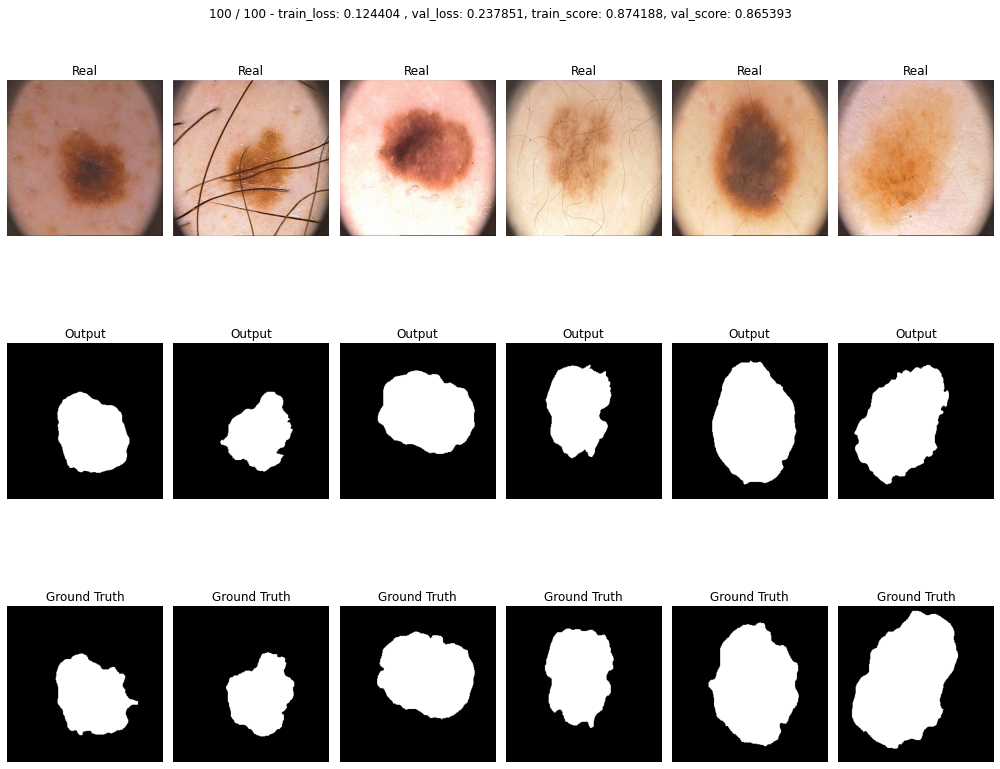

In [ ]:
unet2_bce = UNet2().to(device)

optimizer = torch.optim.AdamW(unet2_bce.parameters(), lr = BASE_LR, betas=(0.9, 0.999), eps=1e-8, weight_decay=WEIGHT_DECAY, amsgrad=AMSGRAD)
h_unet2_bce = train(unet2_bce, optimizer, bce_loss, MAX_EPOCHS, data_tr, data_val, used_sheduler=True)

In [ ]:
unet2_bce_val_score, unet2_bce_test_score = scores(unet2_bce)


Score на валидации: 0.8654, score на тесте: 0.8382


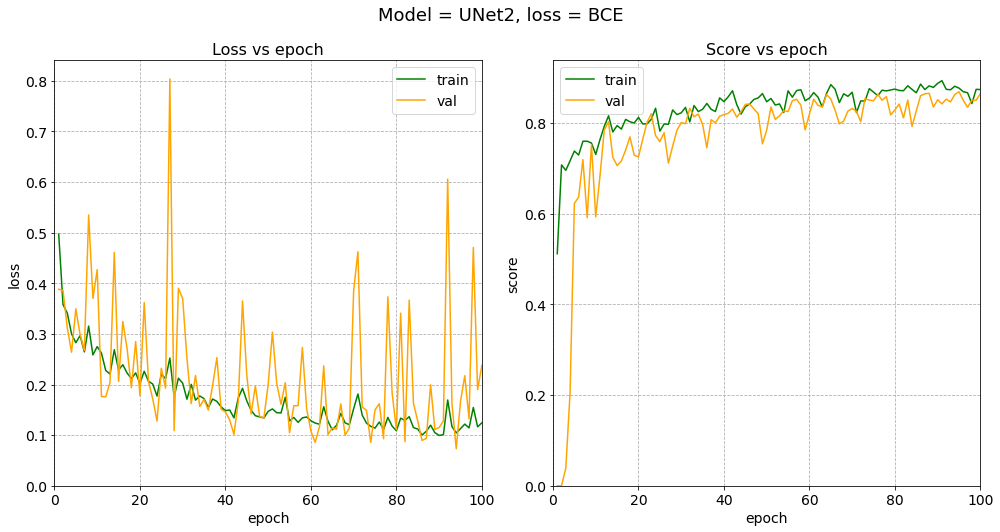

In [ ]:
make_graph(h_unet2_bce, "UNet2", "BCE")

In [ ]:
unet2_bce.to("cpu")
del unet2_bce
torch.cuda.empty_cache()
!nvidia-smi

# *UNet2 + dice loss*

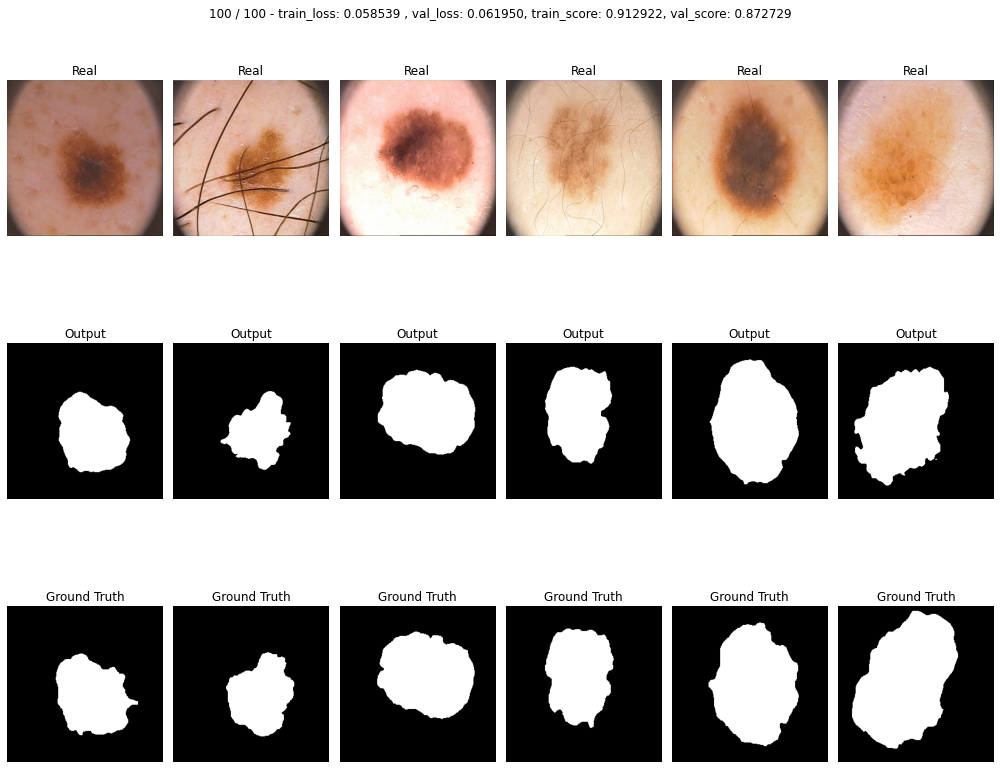

In [ ]:
unet2_dice = UNet2().to(device)

optimizer = torch.optim.AdamW(unet2_dice.parameters(), lr = BASE_LR, betas=(0.9, 0.999), eps=1e-8, weight_decay=WEIGHT_DECAY, amsgrad=AMSGRAD)
h_unet2_dice = train(unet2_dice, optimizer, dice_loss, MAX_EPOCHS, data_tr, data_val, used_sheduler=True)

In [ ]:
unet2_dice_val_score, unet2_dice_test_score = scores(unet2_dice)


Score на валидации: 0.8727, score на тесте: 0.8513


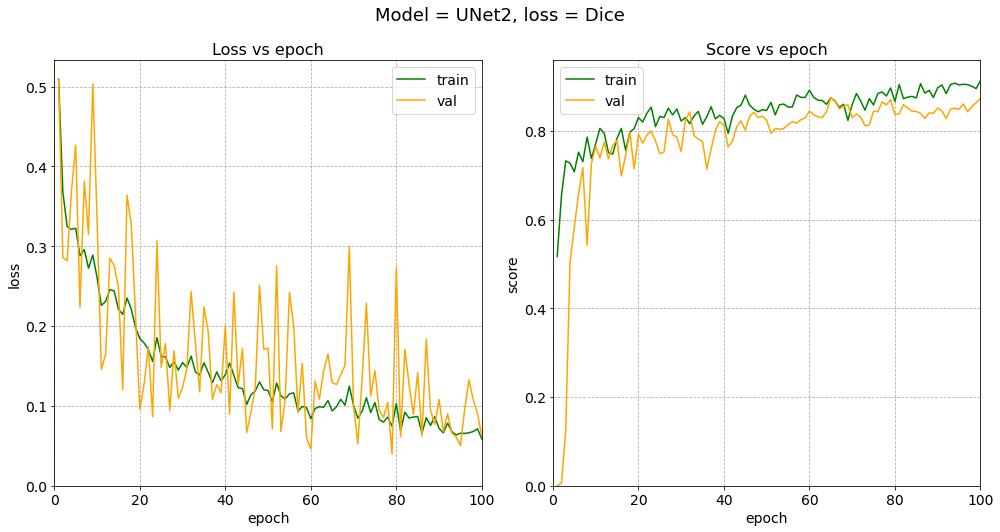

In [ ]:
make_graph(h_unet2_dice, "UNet2", "Dice")

In [ ]:
unet2_dice.to("cpu")
del unet2_dice
torch.cuda.empty_cache()
!nvidia-smi

# *UNet2 + focal loss*

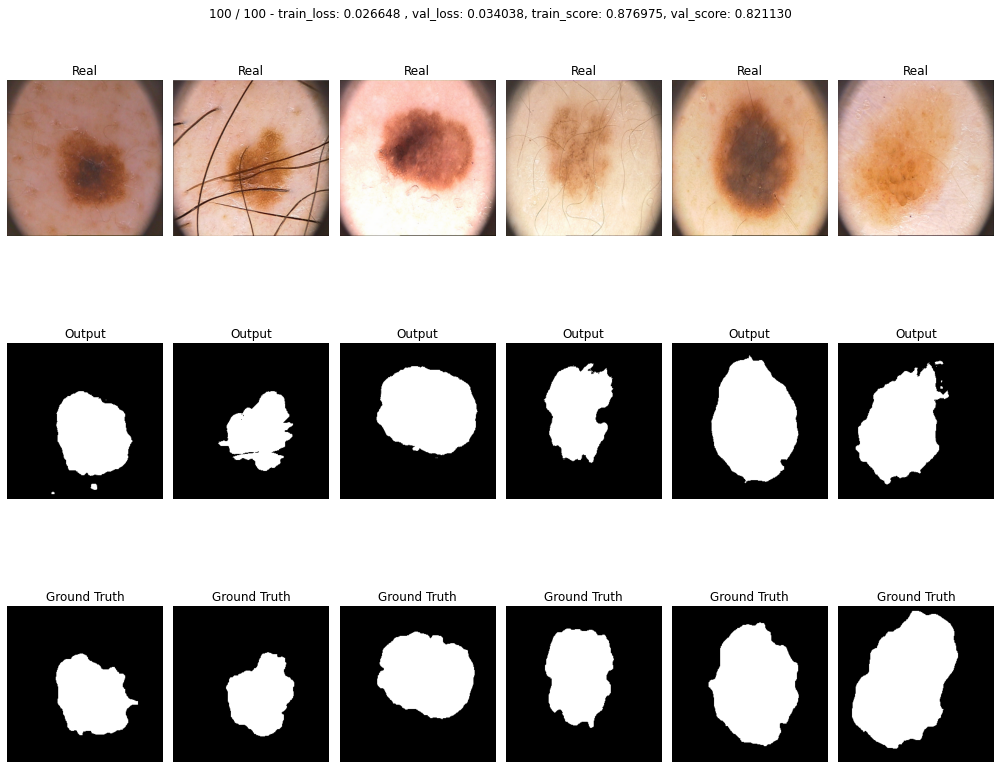

In [ ]:
unet2_focal = UNet2().to(device)

optimizer = torch.optim.AdamW(unet2_focal.parameters(), lr = BASE_LR, betas=(0.9, 0.999), eps=1e-8, weight_decay=WEIGHT_DECAY, amsgrad=AMSGRAD)
h_unet2_focal = train(unet2_focal, optimizer, focal_loss, MAX_EPOCHS, data_tr, data_val, used_sheduler=True)

In [ ]:
unet2_focal_val_score, unet2_focal_test_score = scores(unet2_focal)


Score на валидации: 0.8211, score на тесте: 0.8501


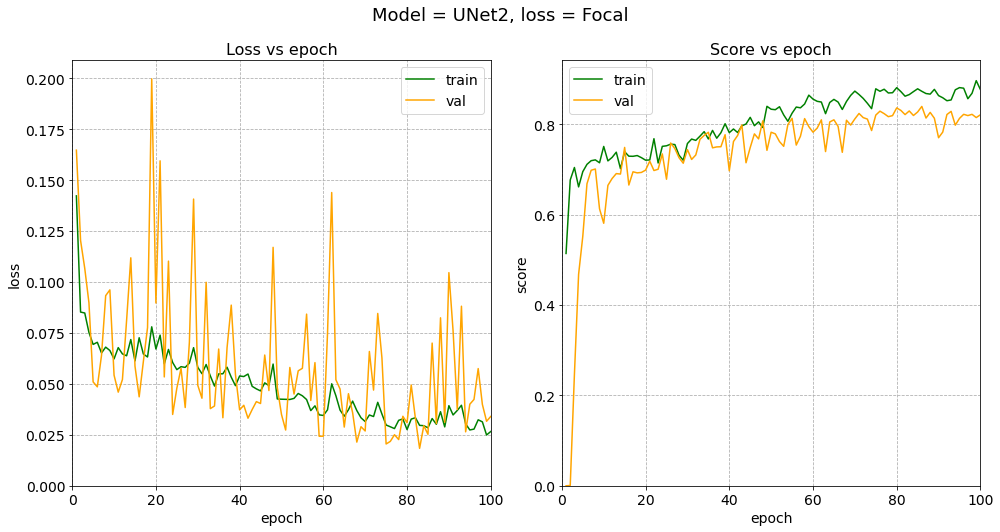

In [ ]:
make_graph(h_unet2_focal, "UNet2", "Focal")

In [ ]:
unet2_focal.to("cpu")
del unet2_focal
torch.cuda.empty_cache()
!nvidia-smi

# *UNet2 + Lovasz loss*

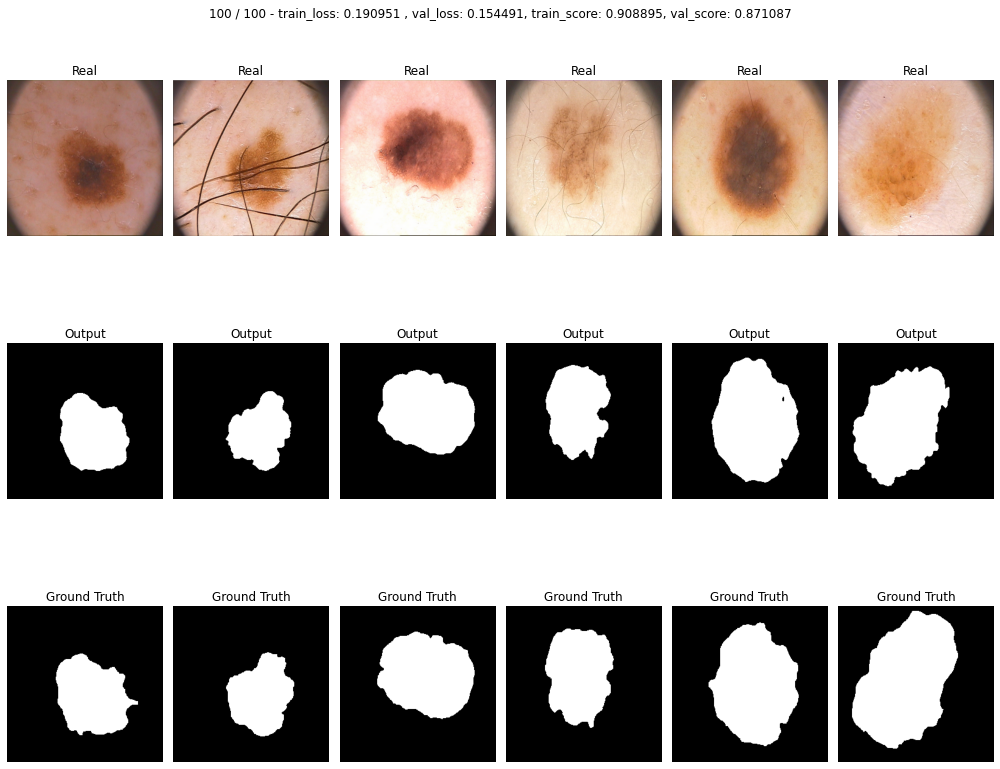

In [ ]:
unet2_lovasz = UNet2().to(device)

optimizer = torch.optim.AdamW(unet2_lovasz.parameters(), lr = BASE_LR, betas=(0.9, 0.999), eps=1e-8, weight_decay=WEIGHT_DECAY, amsgrad=AMSGRAD)
h_unet2_lovasz = train(unet2_lovasz, optimizer, lovasz_loss, MAX_EPOCHS, data_tr, data_val, used_sheduler=True)

In [ ]:
unet2_lovasz_val_score, unet2_lovasz_test_score = scores(unet2_lovasz)


Score на валидации: 0.8711, score на тесте: 0.8505


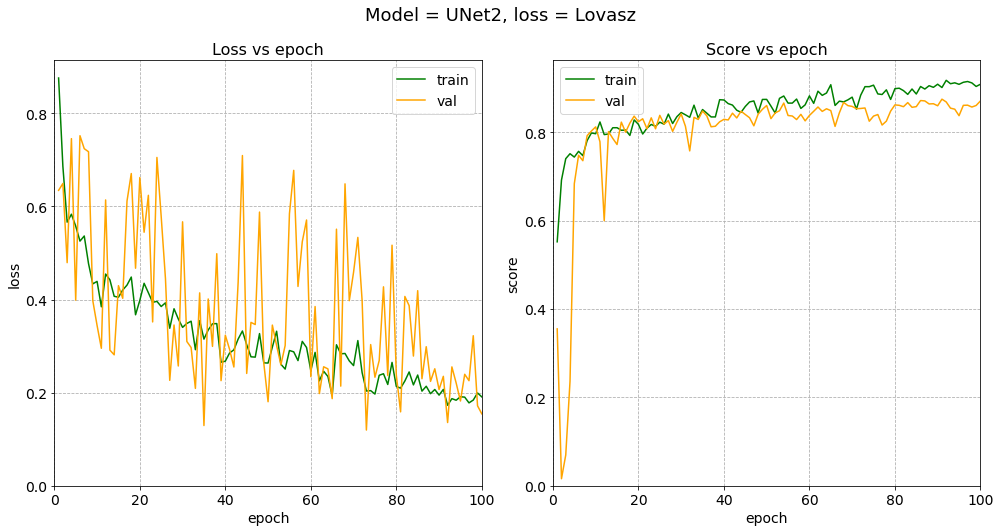

In [ ]:
make_graph(h_unet2_lovasz, "UNet2", "Lovasz")

In [ ]:
unet2_lovasz.to("cpu")
del unet2_lovasz
torch.cuda.empty_cache()
!nvidia-smi

Сделайте вывод, какая из моделей лучше

# Отчет (6 баллов): 
Ниже предлагается написать отчет о проделанно работе и построить графики для лоссов, метрик на валидации и тесте. 
Если вы пропустили какую-то часть в задании выше, то вы все равно можете получить основную часть баллов в отчете, если правильно зададите проверяемые вами гипотезы.


Аккуратно сравните модели между собой и соберите наилучшую архитектуру. Проверьте каждую модель с различными лоссами. Мы не ограничиваем вас в формате отчета, но проверяющий должен отчетливо понять для чего построен каждый график, какие выводы вы из него сделали и какой общий вывод можно сделать на основании данных моделей. Если вы захотите добавить что-то еще, чтобы увеличить шансы получения максимального балла, то добавляйте отдельное сравнение.

Дополнительные комментарии: 

Пусть у вас есть N обученных моделей.
- Является ли отчетом N графиков с 1 линей? Да, но очень низкокачественным, потому что проверяющий не сможет сам сравнить их.

- Является ли отчетом 1 график с N линиями? Да, но скорее всего таким образом вы отразили лишь один эффект. Этого мало, чтобы сделать досточно суждений по поводу вашей работа.

- Я проверял метрики на трейне, и привел в результате таблицу с N числами, что не так? ключейвой момент тут, что вы измеряли на трейне ваши метрики, уверены ли вы, что заивисмости останутся такими же на отложенной выборке?

- Я сделал отчет содержащий график лоссов и метрик, и у меня нет ошибок в основной части, но за отчет не стоит максимум, почему? Естестественно максимум баллов за отчет можно получить не за 2 графика (даже при условии их полной правильности). Проверяющий хочет видеть больше сравнений моделей, чем метрики и лоссы (особенно, если они на трейне).

Советы: попробуйте правильно поставить вопрос на который вы себе отвечаете и продемонстрировать таблицу/график, помогающий проверяющему увидеть ответ на этот вопрос. Пример: Ваня хочет узнать, с каким из 4-х лоссов модель (например, U-Net) имеет наилучшее качество. Что нужно сделать Ване? Обучить 4 одинаковых модели с разными лосс функциями. И измерить итогововое качество. Продемонстрировать результаты своих измерений и итоговый вывод. (warning: конечно же, это не идеально ответит на наш вопрос, так как мы не учитываем в экспериментах возможные различные типы ошибок, но для первого приближения этого вполне достаточно).

Примерное время на подготовку отчета 1 час, он содержит сравнеение метрик, график лоссов, выбор лучших моделей из нескольких кластеров и выбор просто лучшей модели, небольшой вывод по всему дз, возможно сравнение результирующих сегментаций, времени или числа параметров модели, проявляйте креативность.

# Анализ графиков лоссов по эпохам

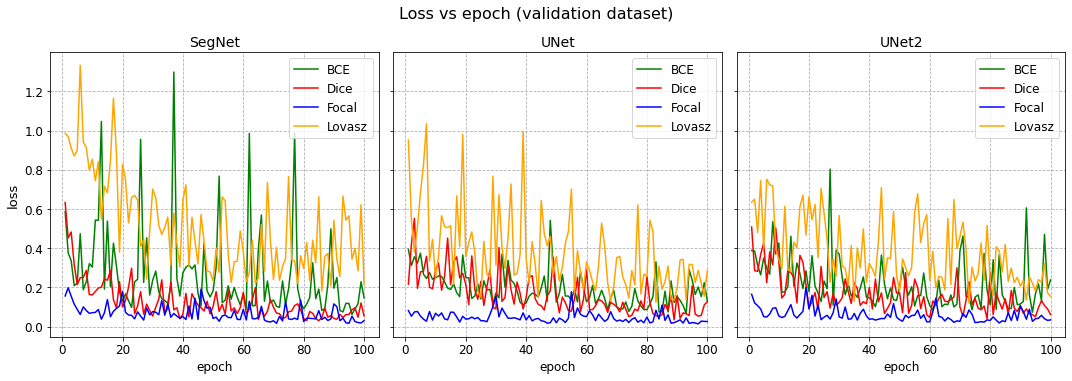

In [ ]:
x = np.arange(100)+1
fig, ax = plt.subplots(1, 3, figsize = (15, 5), sharey = True)

y1 = h_segnet_bce["val"]["loss"]
y2 = h_segnet_dice["val"]["loss"]
y3 = h_segnet_focal["val"]["loss"]
y4 = h_segnet_lovasz["val"]["loss"]
ax[0].plot(x, y1, label = "BCE", color = "green")
ax[0].plot(x, y2, label = "Dice", color = "red")
ax[0].plot(x, y3, label = "Focal", color = "blue")
ax[0].plot(x, y4, label = "Lovasz", color = "orange")
ax[0].legend(fontsize = 12)
ax[0].grid(linestyle = "--")
ax[0].tick_params(labelsize = 12)
ax[0].set_ylabel("loss", fontsize = 13)
ax[0].set_title("SegNet", fontsize = 14)
ax[0].set_xlabel("epoch", fontsize = 12)

y1 = h_unet_bce["val"]["loss"]
y2 = h_unet_dice["val"]["loss"]
y3 = h_unet_focal["val"]["loss"]
y4 = h_unet_lovasz["val"]["loss"]
ax[1].plot(x, y1, label = "BCE", color = "green")
ax[1].plot(x, y2, label = "Dice", color = "red")
ax[1].plot(x, y3, label = "Focal", color = "blue")
ax[1].plot(x, y4, label = "Lovasz", color = "orange")
ax[1].legend(fontsize = 12)
ax[1].grid(linestyle = "--")
ax[1].tick_params(labelsize = 12)
ax[1].set_title("UNet", fontsize = 14)
ax[1].set_xlabel("epoch", fontsize = 12)

y1 = h_unet2_bce["val"]["loss"]
y2 = h_unet2_dice["val"]["loss"]
y3 = h_unet2_focal["val"]["loss"]
y4 = h_unet2_lovasz["val"]["loss"]
ax[2].plot(x, y1, label = "BCE", color = "green")
ax[2].plot(x, y2, label = "Dice", color = "red")
ax[2].plot(x, y3, label = "Focal", color = "blue")
ax[2].plot(x, y4, label = "Lovasz", color = "orange")
ax[2].legend(fontsize = 12)
ax[2].grid(linestyle = "--")
ax[2].tick_params(labelsize = 12)
ax[2].set_title("UNet2", fontsize = 14)
ax[2].set_xlabel("epoch", fontsize = 12)
plt.suptitle(f"Loss vs epoch (validation dataset)", fontsize = 16, y=1.05)
plt.tight_layout()

Lovasz-loss имеет заметно бОльшие значения, как на старте обучения, так и в процессе обучения, в том числе и в конце 100 эпох. В то же время Focal-loss у всех моделей имеет наименьшие значения, что не гарантирует первенство в скоре. Dice-loss и Bce-loss имеют достаточно близкие друг к другу значения на протяжении всех обучаемых эпох и находятся между лидером и аутсайдером.

# Анализ графиков скора по эпохам в зависимости от модели

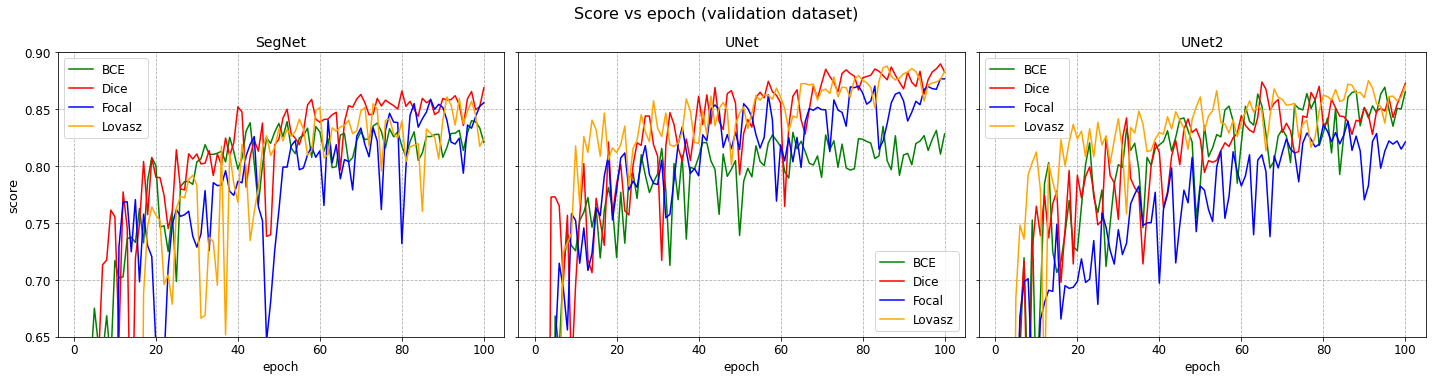

In [ ]:
x = np.arange(100)+1
fig, ax = plt.subplots(1, 3, figsize = (20, 5), sharey = True)

y1 = h_segnet_bce["val"]["score"]
y2 = h_segnet_dice["val"]["score"]
y3 = h_segnet_focal["val"]["score"]
y4 = h_segnet_lovasz["val"]["score"]
ax[0].plot(x, y1, label = "BCE", color = "green")
ax[0].plot(x, y2, label = "Dice", color = "red")
ax[0].plot(x, y3, label = "Focal", color = "blue")
ax[0].plot(x, y4, label = "Lovasz", color = "orange")
ax[0].legend(fontsize = 12)
ax[0].grid(linestyle = "--")
ax[0].tick_params(labelsize = 12)
ax[0].set_ylabel("score", fontsize = 13)
ax[0].set_title("SegNet", fontsize = 14)
ax[0].set_xlabel("epoch", fontsize = 12)
ax[0].set_ylim(0.65, 0.9)

y1 = h_unet_bce["val"]["score"]
y2 = h_unet_dice["val"]["score"]
y3 = h_unet_focal["val"]["score"]
y4 = h_unet_lovasz["val"]["score"]
ax[1].plot(x, y1, label = "BCE", color = "green")
ax[1].plot(x, y2, label = "Dice", color = "red")
ax[1].plot(x, y3, label = "Focal", color = "blue")
ax[1].plot(x, y4, label = "Lovasz", color = "orange")
ax[1].legend(fontsize = 12)
ax[1].grid(linestyle = "--")
ax[1].tick_params(labelsize = 12)
ax[1].set_title("UNet", fontsize = 14)
ax[1].set_xlabel("epoch", fontsize = 12)
ax[1].set_ylim(0.65, 0.9)

y1 = h_unet2_bce["val"]["score"]
y2 = h_unet2_dice["val"]["score"]
y3 = h_unet2_focal["val"]["score"]
y4 = h_unet2_lovasz["val"]["score"]
ax[2].plot(x, y1, label = "BCE", color = "green")
ax[2].plot(x, y2, label = "Dice", color = "red")
ax[2].plot(x, y3, label = "Focal", color = "blue")
ax[2].plot(x, y4, label = "Lovasz", color = "orange")
ax[2].legend(fontsize = 12)
ax[2].grid(linestyle = "--")
ax[2].tick_params(labelsize = 12)
ax[2].set_title("UNet2", fontsize = 14)
ax[2].set_xlabel("epoch", fontsize = 12)
ax[2].set_ylim(0.65, 0.9)
plt.suptitle(f"Score vs epoch (validation dataset)", fontsize = 16, y=1.05)
plt.tight_layout()
plt.show()

Графики показывают явное лидерство модели UNet с любыми лосс-функциями, второе место можно отдать модели UNet2, и далее с небольшим отрывом идет модель SegNet. При этом во всех моделях топовые результаты показывает Lovasz-loss и Dice-loss, в то время как Focal-loss и BCE оказались аутсайдерами.

# Анализ графиков скора по эпохам в зависимости от лосса

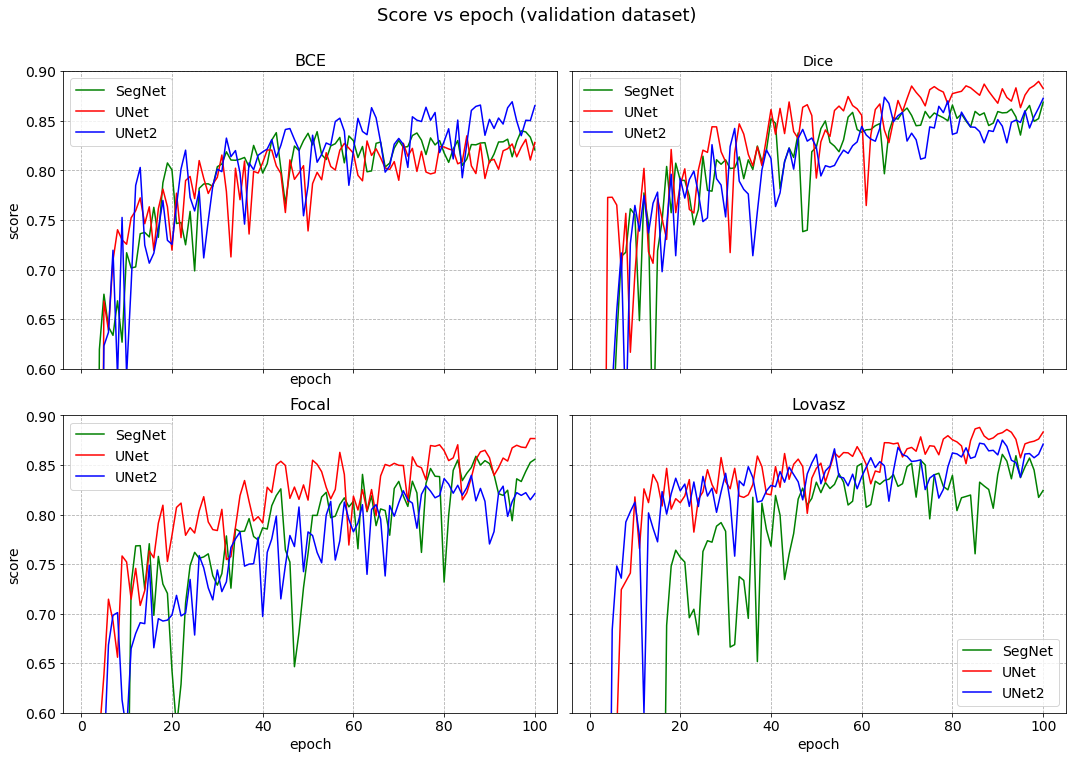

In [ ]:
x = np.arange(100)+1
fig, ax = plt.subplots(2, 2, figsize = (15, 10), sharey = True, sharex = True)
y1 = h_segnet_bce["val"]["score"]
y2 = h_unet_bce["val"]["score"]
y3 = h_unet2_bce["val"]["score"]
ax[0, 0].plot(x, y1, label = "SegNet", color = "green")
ax[0, 0].plot(x, y2, label = "UNet", color = "red")
ax[0, 0].plot(x, y3, label = "UNet2", color = "blue")
ax[0, 0].legend(fontsize = 14)
ax[0, 0].grid(linestyle = "--")
ax[0, 0].tick_params(labelsize = 14)
ax[0, 0].set_ylabel("score", fontsize = 14)
ax[0, 0].set_title("BCE", fontsize = 16)
ax[0, 0].set_xlabel("epoch", fontsize = 14)
ax[0, 0].set_ylim(0.6, 0.9)

y1 = h_segnet_dice["val"]["score"]
y2 = h_unet_dice["val"]["score"]
y3 = h_unet2_dice["val"]["score"]
ax[0, 1].plot(x, y1, label = "SegNet", color = "green")
ax[0, 1].plot(x, y2, label = "UNet", color = "red")
ax[0, 1].plot(x, y3, label = "UNet2", color = "blue")
ax[0, 1].legend(fontsize = 14)
ax[0, 1].grid(linestyle = "--")
ax[0, 1].tick_params(labelsize = 16)
ax[0, 1].set_title("Dice", fontsize = 14)
ax[0, 1].set_ylim(0.6, 0.9)


y1 = h_segnet_focal["val"]["score"]
y2 = h_unet_focal["val"]["score"]
y3 = h_unet2_focal["val"]["score"]
ax[1, 0].plot(x, y1, label = "SegNet", color = "green")
ax[1, 0].plot(x, y2, label = "UNet", color = "red")
ax[1, 0].plot(x, y3, label = "UNet2", color = "blue")
ax[1, 0].legend(fontsize = 14)
ax[1, 0].grid(linestyle = "--")
ax[1, 0].tick_params(labelsize = 14)
ax[1, 0].set_ylabel("score", fontsize = 14)
ax[1, 0].set_title("Focal", fontsize = 16)
ax[1, 0].set_xlabel("epoch", fontsize = 14)
ax[1, 0].set_ylim(0.6, 0.9)


y1 = h_segnet_lovasz["val"]["score"]
y2 = h_unet_lovasz["val"]["score"]
y3 = h_unet2_lovasz["val"]["score"]
ax[1, 1].plot(x, y1, label = "SegNet", color = "green")
ax[1, 1].plot(x, y2, label = "UNet", color = "red")
ax[1, 1].plot(x, y3, label = "UNet2", color = "blue")
ax[1, 1].legend(fontsize = 14)
ax[1, 1].grid(linestyle = "--")
ax[1, 1].tick_params(labelsize = 14)
ax[1, 1].set_title("Lovasz", fontsize = 16)
ax[1, 1].set_xlabel("epoch", fontsize = 14)
ax[1, 1].set_ylim(0.6, 0.9)


plt.suptitle(f"Score vs epoch (validation dataset)", fontsize = 18, y=1.05)
plt.tight_layout()
plt.show()

Данные графики иллюстрируют первенство модели Unet, второе и третье место делят модели UNet2 и Segnet в зависимости от используемых ими типа функции потерь. Напрример, UNet2+Lovasz немного выигрывает у Segnet+Lovasz. Такую же картину мы наблюдаем и в случае сравнения UNet2+Dice/BCE и  Segnet+Dice/BCE.

# Анализ скора на тестовом датасете

In [ ]:
y = [segnet_bce_test_score, segnet_dice_test_score, segnet_focal_test_score, segnet_lovasz_test_score,
     unet_bce_test_score, unet_dice_test_score, unet_focal_test_score, unet_lovasz_test_score,
     unet2_bce_test_score, unet2_dice_test_score, unet2_focal_test_score, unet2_lovasz_test_score]

x = ['segnet_bce', 'segnet_dice', 'segnet_focal', 'segnet_lovasz',
     'unet_bce', 'unet_dice', 'unet_focal', 'unet_lovasz',
     'unet2_bce', 'unet2_dice', 'unet2_focal', 'unet2_lovasz']

from matplotlib import cm
colors = cm.get_cmap("viridis", 12).colors

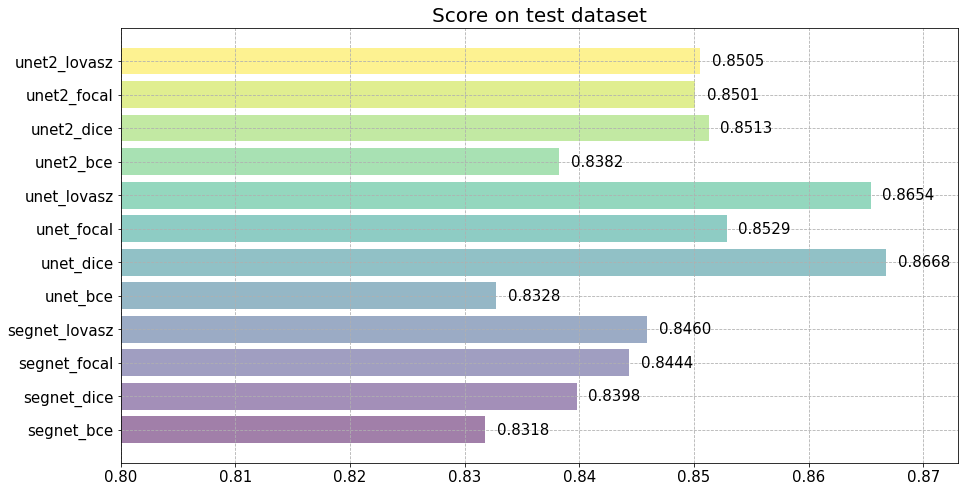

In [ ]:
fig, ax = plt.subplots(figsize = (15, 8))
ax.barh(x, y, color = colors, alpha = 0.5)
ax.set_xlim(0.8, 0.873)
ax.tick_params(labelsize = 15)
for i in range(12):
    ax.text(y[i]+0.001, i - 0.15, f"{y[i]:.4f}", fontsize = 15)
    ax.grid(linestyle="--")
ax.set_title("Score on test dataset", fontsize = 20)
plt.show()

На тестовом датасете отчетливо видно лидерство модели UNet относительно Segnet при любых лосс-функциях. У Segnet лучшим лоссом стал Lovasz, у UNet также лучшим лоссом стал Lovasz, у UNet2 - Lovasz, Dice, Focal одинаково приемлемы и о дают очень близкие результаты. Топовые результаты показали варианты UNet+Dice/Lovasz.
При этом Lovasz-loss можно признать самым оптимальным выбором для любых наших моделей. В то же время BCE-loss оказался наиболее неудачным вариантом.

# Заключение и общие выводы

Проведенный эксперимент рассматривал три нейроные модели Segnet, UNet, UNet2. При этом каждая их перечисленных моделей тестировалась с 4-мя разными типами функции потерь, а именно: BCE, Dice, Focal и Lovasz при неизменных других параметрах, таких как количество эпох, скорость обучения, тип оптимизатора и т.п. Библиотечные реализации лосс-функций по условию ТЗ НЕ использовались. Для улучшения воспроизводимости кода фиксировались случайные инициализации параметров. Вывод эксперимента очевиден: есть явный лидер среди моделей и это - UNet, архитектура которой предусматривает наличие skip-connections. На 2-ом месте с небольшим отрывом идет UNet2. Модель Segnet в эксперименте отстает в результатах от своих соперников. Для лидирующих архитектур моделей типа UNet/UNet2 хорошо зарекомендовала себя такая связка лосс-функций как Lovasz и Dice. BCE оказался не самым удачным выбором для всех моделей. При этом Lovasz можно охарактеризовать как оптимальный выбор для любой архитектуры. При обучении моделей использовался оптимизатор adamW, параметры которого подбирались несколькими итерациями в процессе обучения моделей для получения наибольших значений scor. Подобранный learning_rate и использование соответствующего scheduler-а позволило обойти проблему значительного переобучения CNN-моделей, что заметно по полученным графическим данным. Обучение всех 12-ти итераций проводено в Google-Colab за 1 сеанс, что потребовало пристального внимания за наполнением\очисткой выделенной VRAM. Внутри каждого цикла обучения мы высвобождали VRAM на GPU от различных батч-данных, а также, после обучения конкретной модели требовался её перенос на CPU с последующим удалением и очисткой кеша. При этом каждой цикл обучения по 100 эпохам на GPU занимал около 10 минут.